Main goal of this notebook is to use the google earth engine to identify and create features that represent the shoreline/waterline of the wetland projects based on different parameters like NDWI, VV and VH backscatter, and individual mutispectral bands

In [ ]:
## before anything you need to visit the site below and make sure you have a google earth engine account
## this is so you can access Sentinel-1 GRD and Sentinel-2 TOA and SR products, as well as other sensor packages and data types

## visit the below website below to setup an earth engine account, enable a cloud project, and enable the ee API 
## https://developers.google.com/earth-engine/cloud/earthengine_cloud_project_setup#get-access-to-earth-engine

In [30]:
import ee
import geemap
import geemap.colormaps as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import math

In [ ]:
## only need to run this once
## after authenticating with google earth engine you will only need to initialize each session

## https://developers.google.com/earth-engine/guides/auth
ee.Authenticate()

In [3]:
## init ee cloud project you made during initial setup
ee.Initialize(project = 'ee-claycaldgsl') ##enter your project name here as a string to initialize exchanges with ee api

# Some functions for a bit easier mapping
super simple for now, might make them better later

In [4]:
## Function to add RGB images to the map.
def add_rgb_to_map(image, map_object):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    map_object.addLayer(image, {'min': 0, 'max': 2000, 'bands': ['B4', 'B3', 'B2']}, f'{date}_rgb')

## Function to add spectral indices images to the map.
def add_ind_to_map(image, map_object, band):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    if band =='NDWI':
        map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': cm.palettes.ndwi}, f'{date}_{band}')
    elif band =='NDVI': 
        map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': cm.palettes.ndvi}, f'{date}_{band}')
    elif band == 'MSAVI2':
        map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': cm.palettes.RdYlGn}, f'{date}_{band}')
    elif band == 'BSI':
        map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': cm.palettes.Greens}, f'{date}_{band}')

## Function to add spectral indices images to the map.
def add_sar_to_map(image, map_object, target_band):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    map_object.addLayer(image, {'min': -50, 'max': 1, 'bands': target_band}, f'{date}_{target_band}')

In [5]:
## functiont to create three important and popular spectral indices
## ndvi = Normalized Difference Vegetation Index, good for vegetation health and cover
## ndwi = Normalized Difference Water Index, good for identifying water bodies and mositure in surface
def s2_10m_target_indices(image):
    # Calculate NDVI
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    # Calculate NDWI
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    # Calculate MSAVI2
    msavi2 = image.expression(
        '((2 * NIR + 1) - ((2 * NIR + 1) ** 2 - 8 * (NIR - RED)) ** 0.5) / 2',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }
    ).rename('MSAVI2')
    
    # Resample the SWIR1 band to match the resolution of the other bands (10 meters)
    # swir1_resampled = image.select('B11').reproject(crs = msavi2.projection(), scale = 10)
    
    # Calculate the Bare-Soil Index (BSI)
    bsi = image.expression(
        '((SWIR1 + RED) - (NIR + BLUE)) / ((SWIR1 + RED) + (NIR + BLUE))',
        {
            'RED': image.select('B4'),
            'NIR': image.select('B8'),
            'BLUE': image.select('B2'),
            'SWIR1': image.select('B11').resample(mode = 'bicubic') ### scale of 10m specified when exporting images
        }
    ).rename('BSI')
    
    # Add all indices as new bands to the image
    return image.addBands([ndvi, ndwi, msavi2, bsi])

## collects sentinel-1 GRD (radar, no phase) and Sentinel-2 SR (multispectral, adjusted for top of atmosphere reflectance)
def get_sentinel_imagery(aoi, start_date, end_date, s2_cloud_cov, orbit):
    ## Sentinel-1 ImageCollection
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.eq('orbitProperties_pass', orbit))
               .select(['VV', 'VH'])
               .sort('date')
    )

    s1= s1.map(lambda img: img.clip(aoi))
    ## Sentinel-2 Surface Reflectance Harmonized ImageCollection
    s2_10m = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', s2_cloud_cov))
               .sort('date')
               .select(['B2', 'B3', 'B4', 'B8', 'B11'])
    )
    ## Clip all images in the collection to the AOI
    s2_10m = s2_10m.map(lambda img: img.clip(aoi))
    ## Apply indices to the Sentinel-2 images
    s2_10m_ndvi = s2_10m.map(s2_10m_target_indices).select(['NDVI'])
    s2_10m_ndwi = s2_10m.map(s2_10m_target_indices).select(['NDWI'])
    s2_10m_msavi2 = s2_10m.map(s2_10m_target_indices).select(['MSAVI2'])
    s2_10m_bsi = s2_10m.map(s2_10m_target_indices).select(['BSI'])

    
    # return s1_VV, s1_VH, s2_10m, s2_10m_ndvi, s2_10m_ndwi, s2_10m_msavi2, s2_10m_bsi
    return s1, s2_10m, s2_10m_ndvi, s2_10m_ndwi, s2_10m_msavi2, s2_10m_bsi

In [6]:
## fucntion to get the date of each image in the image collection
def get_date(image):
    return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd')})

In [7]:
# Define a function to get histogram of NDWI for each image
def get_histogram(image, scale, bucket_num, band_name):
    """
    Used to create ndwi histograms for the imagery

    image = ee.Image
        NDWI image to determine the shoreline from
    scale = int
        scale to estimate the histogram from, typically 10 to match the resolution of the RGB imagery
    bucket_num = int
        number of buckets to put the data into for histogram
    band_name = str
        the name of your target band in the image
    """


    # Reduce the image to get a histogram over the region of interest (ROI)
    hist = image.reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=bucket_num),  # Adjust the number of buckets as needed
        geometry=aoi,
        scale=scale,  # Adjust based on image resolution
        maxPixels=1e8
    )
    
    # Get the histogram data for NDWI
    histogram = ee.Dictionary(hist.get(band_name)).getInfo() 
    
    return histogram

In [8]:
def otsu_trimodal_from_histogram(histogram):
    # Extract histogram and means from the provided NDWI histogram
    counts = np.array(histogram['histogram'])
    means = np.array(histogram['bucketMeans'])
    total = np.sum(counts)
    sum_values = np.sum(means * counts)
    overall_mean = sum_values / total
    size = len(means)

    # Define a function to compute the between-class variance (BSS)
    def compute_intervariance(i, k):
        # Compute for first region (A)
        aCounts = counts[:i]
        aCount = np.sum(aCounts)
        aMeans = means[:i]
        aMean = np.sum(aMeans * aCounts) / aCount if aCount != 0 else 0

        # Compute for second region (B)
        bCounts = counts[i:k]
        bCount = np.sum(bCounts)
        bMeans = means[i:k]
        bMean = np.sum(bMeans * bCounts) / bCount if bCount != 0 else 0

        # Compute for third region (C)
        cCounts = counts[k:]
        cCount = np.sum(cCounts)
        cMeans = means[k:]
        cMean = np.sum(cMeans * cCounts) / cCount if cCount != 0 else 0

        # Return combined BSS
        return aCount * (aMean - overall_mean) ** 2 + \
               bCount * (bMean - overall_mean) ** 2 + \
               cCount * (cMean - overall_mean) ** 2

    # Initialize an empty list for BSS values
    bss_values = []
    
    # Iterate through potential thresholds
    for i in range(1, size - 1):  # Start at 1, and stop before the last element
        for k in range(i + 1, size):  # Ensure k is always greater than i
            bss_values.append(compute_intervariance(i, k))

    # Convert BSS values to a NumPy array
    bss_array = np.array(bss_values)

    # Find indices of maximum BSS
    max_bss_index = np.argmax(bss_array)
    
    # Convert the flat index back to i and k values
    i_max = max_bss_index // (size - 1)
    k_max = max_bss_index % (size - 1)

    # Return corresponding means for the threshold
    return means[i_max], means[k_max]

In [9]:
# Function to calculate statistics for NDVI and NDMI over AOIs
def extract_statistics(image, index_name):
    # Reduce the image over the AOIs using mean, max, and min reducers
    stats = image.reduceRegions(
        collection=aois,
        reducer=ee.Reducer.minMax().combine(
            reducer2=ee.Reducer.percentile([25, 50, 75]).combine(
                reducer2=ee.Reducer.mean().combine(
                    reducer2=ee.Reducer.stdDev(),
                    sharedInputs=True
                ),
                sharedInputs=True
            ),
            sharedInputs=True
        ),
        scale=10
    )
    
    # Add the date of the image as a property to each feature in the collection
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    stats = stats.map(lambda f: f.set('date', date))
    
    return stats

# my function needs im_coll, index_name, and aoi

def extract_stats_from_aoi(image_collection, index_name, aoi):
    stats_ims = image_collection.map(lambda img: img.clip(aoi))
    stats_collection = stats_ims.map(lambda img: extract_statistics(img, index_name)).flatten()
    statslist = stats_collection.getInfo()['features']

    data=[]
    for feature in statslist:
        properties = feature['properties']
        data_dict = {}
        for key in properties:
            data_dict[f'{key}'] = properties[key]
        data.append(data_dict)

    df = pd.DataFrame(data)

    # Convert the date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Sort the DataFrame by date
    df = df.sort_values(by='date')
    df.dropna(inplace=True)
    return df

In [10]:
def plot_VI_ts(aoi, aoi_str, plottype):
    # Plotting the mean, standard deviation, and quartiles
    if plottype == 'together':
    
        plt.figure(figsize=(14, 7))

        for imcoll in [total_colls['s2_10m_ndvi'], total_colls['s2_10m_ndwi'], total_colls['s2_10m_msavi2']]:
            if imcoll == total_colls['s2_10m_ndvi']:
                df = extract_stats_from_aoi(imcoll, 'NDVI', aoi)
                plt.plot(df['date'], df['mean'], color='green', marker='o', linestyle='-', label='Mean NDVI')
                plt.fill_between(df['date'],
                                df['mean'] - df['stdDev'],
                                df['mean'] + df['stdDev'],
                                color='green', alpha=0.2, label='NDVI ± 1 Std Dev'
                            )

                # Plot NDVI Interquartile Range (IQR)
                plt.fill_between(df['date'],
                                df['p25'],
                                df['p75'],
                                color='green', alpha=0.5, linestyle='-', label='NDVI IQR (25th to 75th Percentile)'
                            )

            elif imcoll == total_colls['s2_10m_ndwi']:
            # Plot NDVI Mean with ±1 Std Dev Shading
                df = extract_stats_from_aoi(imcoll, 'NDWI', aoi)
                plt.plot(df['date'], df['mean'], color='blue', marker='o', linestyle='-', label='Mean NDWI')
                plt.fill_between(df['date'],
                                    df['mean'] - df['stdDev'],
                                    df['mean'] + df['stdDev'],
                                    color='blue', alpha=0.2, label='NDVI ± 1 Std Dev'
                                )

                # Plot NDVI Interquartile Range (IQR)
                plt.fill_between(df['date'],
                                    df['p25'],
                                    df['p75'],
                                    color='blue', alpha=0.5, linestyle='-', label='NDWI IQR (25th to 75th Percentile)'
                                )
                
            elif imcoll == total_colls['s2_10m_msavi2']:
                df = extract_stats_from_aoi(imcoll, 'MSAVI2', aoi)
                plt.plot(df['date'], df['mean'], color='red', marker='o', linestyle='-', label='Mean MSAVI2')
                plt.fill_between(df['date'],
                                df['mean'] - df['stdDev'],
                                df['mean'] + df['stdDev'],
                                color='red', alpha=0.2, label='MSAVI2 ± 1 Std Dev'
                            )

                # Plot MSAVI2 Interquartile Range (IQR)
                plt.fill_between(df['date'],
                                df['p25'],
                                df['p75'],
                                color='red', alpha=0.5, linestyle='-', label='MSAVI2 IQR (25th to 75th Percentile)'
                            )

        # Add vertical lines for Hurricane Laura and Hurricane Delta
        storm_dates = {
            'Hurricane Laura': pd.to_datetime('2020-08-27'),
            'Hurricane Delta': pd.to_datetime('2020-10-09'),
            'Hurricane Zeta': pd.to_datetime('2020-10-28'),
            'Hurricane Ida': pd.to_datetime('2021-08-29'),
            'Hurricane Beryl': pd.to_datetime('2024-07-24'),
            'Hurricane Francine': pd.to_datetime('2024-09-11')
        }

        for storm, date in storm_dates.items():
            if storm[0] == 'H':
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)
                
        # Customizing the plot
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'NDVI, NDWI, and MSAVI2 Change Over Time for {aoi_str}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()
    
    elif plottype == 'separate':
        
        plt.figure(figsize=(14,7))

        df = extract_stats_from_aoi(total_colls['s2_10m_ndvi'], 'NDVI', aoi)
        plt.plot(df['date'], df['mean'], color='green', marker='o', linestyle='-', label='Mean NDVI')
        plt.fill_between(df['date'],
                        df['mean'] - df['stdDev'],
                        df['mean'] + df['stdDev'],
                        color='green', alpha=0.2, label='NDVI ± 1 Std Dev'
                    )

        # Plot NDVI Interquartile Range (IQR)
        plt.fill_between(df['date'],
                        df['p25'],
                        df['p75'],
                        color='green', alpha=0.5, linestyle='-', label='NDVI IQR (25th to 75th Percentile)'
                    )
        
        # Add vertical lines for Hurricane Laura and Hurricane Delta
        storm_dates = {
            'Hurricane Laura': pd.to_datetime('2020-08-27'),
            'Hurricane Delta': pd.to_datetime('2020-10-09'),
            'Hurricane Zeta': pd.to_datetime('2020-10-28'),
            'Hurricane Ida': pd.to_datetime('2021-08-29'),
            'Hurricane Beryl': pd.to_datetime('2024-07-24'),
            'Hurricane Francine': pd.to_datetime('2024-09-11')
        }

        for storm, date in storm_dates.items():
            if storm[0] == 'H':
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        # Customizing the plot
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'NDVI Change Over Time for {aoi_str}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()

        plt.figure(figsize=(14,7))
        df = extract_stats_from_aoi(total_colls['s2_10m_ndwi'], 'NDWI', aoi)
        plt.plot(df['date'], df['mean'], color='blue', marker='o', linestyle='-', label='Mean NDWI')
        plt.fill_between(df['date'],
                        df['mean'] - df['stdDev'],
                        df['mean'] + df['stdDev'],
                        color='blue', alpha=0.2, label='NDWI ± 1 Std Dev'
                    )

        # Plot NDWI Interquartile Range (IQR)
        plt.fill_between(df['date'],
                        df['p25'],
                        df['p75'],
                        color='blue', alpha=0.5, linestyle='-', label='NDWI IQR (25th to 75th Percentile)'
                    )
        
        # Add vertical lines for Hurricane Laura and Hurricane Delta
        storm_dates = {
            'Hurricane Laura': pd.to_datetime('2020-08-27'),
            'Hurricane Delta': pd.to_datetime('2020-10-09'),
            'Hurricane Zeta': pd.to_datetime('2020-10-28'),
            'Hurricane Ida': pd.to_datetime('2021-08-29'),
            'Hurricane Beryl': pd.to_datetime('2024-07-24'),
            'Hurricane Francine': pd.to_datetime('2024-09-11')
        }

        for storm, date in storm_dates.items():
            if storm[0] == 'H':
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        # Customizing the plot
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'NDWI Change Over Time for {aoi_str}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()

        plt.figure(figsize=(14,7))

        df = extract_stats_from_aoi(total_colls['s2_10m_msavi2'], 'MSAVI2', aoi)
        plt.plot(df['date'], df['mean'], color='red', marker='o', linestyle='-', label='Mean MSAVI2')
        plt.fill_between(df['date'],
                        df['mean'] - df['stdDev'],
                        df['mean'] + df['stdDev'],
                        color='red', alpha=0.2, label='MSAVI2 ± 1 Std Dev'
                    )

        # Plot NDVI Interquartile Range (IQR)
        plt.fill_between(df['date'],
                        df['p25'],
                        df['p75'],
                        color='red', alpha=0.5, linestyle='-', label='MSAVI2 IQR (25th to 75th Percentile)'
                    )
        
        # Add vertical lines for Hurricane Laura and Hurricane Delta
        storm_dates = {
            'Hurricane Laura': pd.to_datetime('2020-08-27'),
            'Hurricane Delta': pd.to_datetime('2020-10-09'),
            'Hurricane Zeta': pd.to_datetime('2020-10-28'),
            'Hurricane Ida': pd.to_datetime('2021-08-29'),
            'Hurricane Beryl': pd.to_datetime('2024-07-24'),
            'Hurricane Francine': pd.to_datetime('2024-09-11')
        }

        for storm, date in storm_dates.items():
            if storm[0] == 'H':
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        # Customizing the plot
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'MSAVI2 Change Over Time for {aoi_str}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()

In [11]:
def plot_GRD_ts(aoi, aoi_str, plottype, imcoll):
    # Plotting the mean, standard deviation, and quartiles
    if plottype == 'together':
        plt.figure(figsize=(14, 7))

        for band in ['VV', 'VH']:
            df = extract_stats_from_aoi(imcoll, band, aoi)
            if band == 'VV':
                color = 'blue'
            elif band == 'VH':
                color = 'green'


            plt.plot(df['date'], df[f'{band}_mean'], color=color, marker='o', linestyle='-', label=f'Mean {band} Backscatter')
            plt.fill_between(df['date'],
                            df[f'{band}_mean'] - df[f'{band}_stdDev'],
                            df[f'{band}_mean'] + df[f'{band}_stdDev'],
                            color=color, alpha=0.2, label=f'{band} Backscatter ± 1 Std Dev'
                        )
            # Plot VV Interquartile Range (IQR)
            plt.fill_between(df['date'],
                            df[f'{band}_p25'],
                            df[f'{band}_p75'],
                            color=color, alpha=0.5, linestyle='-', label=f'{band} Backascatter IQR (25th to 75th Percentile)'
                        )


        # Add vertical lines for Hurricane Laura and Hurricane Delta
        storm_dates = {
            'Hurricane Laura': pd.to_datetime('2020-08-27'),
            'Hurricane Delta': pd.to_datetime('2020-10-09'),
            'Hurricane Zeta': pd.to_datetime('2020-10-28'),
            'Hurricane Ida': pd.to_datetime('2021-08-29'),
            'Hurricane Beryl': pd.to_datetime('2024-07-24'),
            'Hurricane Francine': pd.to_datetime('2024-09-11')
        }

        for storm, date in storm_dates.items():
            if storm[0] == 'H':
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        
        # Customizing the plot
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'Sentinel-1 Backscatter Amplitude Change Over Time for {aoi_str}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()

    elif plottype == 'separate':
        df = extract_stats_from_aoi(imcoll, 'VV', aoi)
        plt.plot(df['date'], df['mean'], color='green', marker='o', linestyle='-', label='Mean VV Backscatter')
        plt.fill_between(df['date'],
                        df['VV_mean'] - df['VV_stdDev'],
                        df['VV_mean'] + df['VV_stdDev'],
                        color='green', alpha=0.2, label='VV Backscatter ± 1 Std Dev'
                    )

        # Plot VV Interquartile Range (IQR)
        plt.fill_between(df['date'],
                        df['VV_p25'],
                        df['VV_p75'],
                        color='green', alpha=0.5, linestyle='-', label='VV Backascatter IQR (25th to 75th Percentile)'
                    )
        
        # Add vertical lines for Hurricane Laura and Hurricane Delta
        storm_dates = {
            'Hurricane Laura': pd.to_datetime('2020-08-27'),
            'Hurricane Delta': pd.to_datetime('2020-10-09'),
            'Hurricane Zeta': pd.to_datetime('2020-10-28'),
            'Hurricane Ida': pd.to_datetime('2021-08-29'),
            'Hurricane Beryl': pd.to_datetime('2024-07-24'),
            'Hurricane Francine': pd.to_datetime('2024-09-11')
        }

        for storm, date in storm_dates.items():
            if storm[0] == 'H':
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        # Customizing the plot
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'Sentinel-1 VV Backscatter Amplitude Change Over Time for {aoi_str}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()


        df = extract_stats_from_aoi(imcoll, 'VH', aoi)
        plt.plot(df['date'], df['VH_mean'], color='blue', marker='o', linestyle='-', label='Mean VH Backscatter')
        plt.fill_between(df['date'],
                        df['VH_mean'] - df['VH_stdDev'],
                        df['VH_mean'] + df['VH_stdDev'],
                        color='blue', alpha=0.2, label='VH Backscatter ± 1 Std Dev'
                    )

        # Plot VV Interquartile Range (IQR)
        plt.fill_between(df['date'],
                        df['VH_p25'],
                        df['VH_p75'],
                        color='blue', alpha=0.5, linestyle='-', label='VH Backascatter IQR (25th to 75th Percentile)'
                    )
        

        # Add vertical lines for Hurricane Laura and Hurricane Delta
        storm_dates = {
            'Hurricane Laura': pd.to_datetime('2020-08-27'),
            'Hurricane Delta': pd.to_datetime('2020-10-09'),
            'Hurricane Zeta': pd.to_datetime('2020-10-28'),
            'Hurricane Ida': pd.to_datetime('2021-08-29'),
            'Hurricane Beryl': pd.to_datetime('2024-07-24'),
            'Hurricane Francine': pd.to_datetime('2024-09-11')
        }

        for storm, date in storm_dates.items():
            if storm[0] == 'H':
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        # Customizing the plot
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'Sentinel-1 VH Backscatter Amplitude Change Over Time for {aoi_str}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()

In [12]:
def extract_land(rgb_coll, ndwi_coll, ndvi_coll):
    land_area = []

    rgb_ims = rgb_coll.toList(rgb_coll.size())
    ndwi_ims = ndwi_coll.toList(ndwi_coll.size())
    ndvi_ims = ndvi_coll.toList(ndvi_coll.size())

    # Iterate over each image in the collection
    for i in range(ndwi_coll.size().getInfo()):
        # Get NDWI and NDVI masks
        ndwi_image = ee.Image(ndwi_ims.get(i))
        ndvi_image = ee.Image(ndvi_ims.get(i))

        # Create water mask from NDWI and land mask from NDVI
        watermask = ndwi_image.select('NDWI').lt(0.0)  # Water is NDWI < 0
        landmask = ndvi_image.select('NDVI').gt(0.0)  # Land is NDVI > 0
        
        # Apply the combined land mask to the RGB image (where watermask AND landmask are valid)
        combined_mask = landmask.And(watermask)
        masked_rgb = ee.Image(rgb_ims.get(i)).updateMask(combined_mask)
        
        land_area.append(masked_rgb)

    # Return land area as an ImageCollection
    land_area_coll = ee.ImageCollection(land_area)
    return land_area_coll

def calculate_land_area(image):
    pixel_area = ee.Image.pixelArea()  # Pixel area in square meters
    
    # Get the land area in square meters
    land_area = image.select('B8').multiply(pixel_area)  # Use the NIR band for land area
    
    # Sum up the total land area for the AOI
    total_land_area_m2 = land_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        # geometry=aois,
        scale=10,  # Sentinel-2 resolution is 10 meters
        maxPixels=1e9
    ).get('B8')  # Sum of the NIR band for total land area

    # Convert from square meters to square kilometers
    total_land_area_km2 = ee.Number(total_land_area_m2).divide(1e9)  # 1 km² = 1,000,000 m²
    
    # Ensure the total area is positive (in case of any negative values)
    total_land_area_km2 = total_land_area_km2.abs()

    # Set the total land area as a property on the image
    return image.set('total_land_area', total_land_area_km2)

In [13]:
def find_closest_dates(s2_dates, s1_dates):
    matched_pairs = []
    
    for s2_date in s2_dates:
        # Find the Sentinel-1 date with the smallest difference
        closest_s1_date = min(s1_dates, key=lambda s1_date: abs(s1_date - s2_date))
        matched_pairs.append((s2_date, closest_s1_date))
    
    return matched_pairs

In [14]:
# Function to filter the existing ImageCollections by a specific date
def filter_image_by_date(collection, date_str):
    date = ee.Date(date_str)
    # Filter the collection by the specified date and return the first image
    return collection.filterDate(date, date.advance(1, 'day')).first()

# Function to match Sentinel-1 and Sentinel-2 images using the date pairs
def match_collections_by_dates(s2_collection, s1_collection, matched_dates):

    matched_images = []
    
    for s2_date, s1_date in matched_dates:
        # Filter the collections by the matched dates
        s2_img = filter_image_by_date(s2_collection, s2_date)
        s1_img = filter_image_by_date(s1_collection, s1_date)
        
        # Combine the images (stack bands) from both Sentinel-2 and Sentinel-1
        combined_img = ee.Image.cat(s2_img, s1_img)
        
        # Add the combined image to the list
        matched_images.append(combined_img)
    
    # Convert the list of combined images into an ImageCollection
    return ee.ImageCollection(matched_images)

In [15]:
# ---------------------------------------------------------------------------//
# 1.SPECKLE FILTERS
# ---------------------------------------------------------------------------//

def boxcar(image, KERNEL_SIZE):
    """
    Apply boxcar filter on every image in the collection.

    Parameters
    ----------
    image : ee.Image
        Image to be filtered
    KERNEL_SIZE : positive odd integer
        Neighbourhood window size

    Returns
    -------
    ee.Image
        Filtered Image

    """
    bandNames = image.bandNames().remove('angle')
      #Define a boxcar kernel
    kernel = ee.Kernel.square((KERNEL_SIZE/2), units='pixels', normalize=True)
     #Apply boxcar
    output = image.select(bandNames).convolve(kernel).rename(bandNames)
    return image.addBands(output, None, True)

def leefilter(image, KERNEL_SIZE):
    """
    Lee Filter applied to one image.
    It is implemented as described in
    J. S. Lee, “Digital image enhancement and noise filtering by use of local statistics,”
    IEEE Pattern Anal. Machine Intell., vol. PAMI-2, pp. 165–168, Mar. 1980.

    Parameters
    ----------
    image : ee.Image
        Image to be filtered
    KERNEL_SIZE : positive odd integer
        Neighbourhood window size

    Returns
    -------
    ee.Image
        Filtered Image

    """
    bandNames = image.bandNames().remove('angle')

    # S1-GRD images are multilooked 5 times in range
    enl = 5
    # Compute the speckle standard deviation
    eta = 1.0/math.sqrt(enl)
    eta = ee.Image.constant(eta)

    # MMSE estimator
    # Neighbourhood mean and variance
    oneImg = ee.Image.constant(1)
    # Estimate stats
    reducers = ee.Reducer.mean().combine(
                      reducer2= ee.Reducer.variance()
                      ,sharedInputs= True
                      )
    stats = (image.select(bandNames).reduceNeighborhood(
                      reducer= reducers
                          ,kernel= ee.Kernel.square(KERNEL_SIZE/2, 'pixels')
                              ,optimization= 'window'))
    meanBand = bandNames.map(lambda bandName: ee.String(bandName).cat('_mean'))
    varBand = bandNames.map(lambda bandName:  ee.String(bandName).cat('_variance'))

    z_bar = stats.select(meanBand)
    varz = stats.select(varBand)
    # Estimate weight 
    varx = (varz.subtract(z_bar.pow(2).multiply(eta.pow(2)))).divide(oneImg.add(eta.pow(2)))
    b = varx.divide(varz)
  
    # if b is negative set it to zero
    new_b = b.where(b.lt(0), 0)
    output = oneImg.subtract(new_b).multiply(z_bar.abs()).add(new_b.multiply(image.select(bandNames)))
    output = output.rename(bandNames)
    return image.addBands(output, None, True)


def gammamap(image,KERNEL_SIZE): 
    
    """
    Gamma Maximum a-posterior Filter applied to one image. It is implemented as described in 
    Lopes A., Nezry, E., Touzi, R., and Laur, H., 1990.  
    Maximum A Posteriori Speckle Filtering and First Order texture Models in SAR Images.  
    International  Geoscience  and  Remote  Sensing  Symposium (IGARSS).
    Parameters
    ----------
    image : ee.Image
        Image to be filtered
    KERNEL_SIZE : positive odd integer
        Neighbourhood window size
    Returns
    -------
    ee.Image
        Filtered Image
    """
    enl = 5
    bandNames = image.bandNames().remove('angle')
    #local mean
    reducers = ee.Reducer.mean().combine( \
                      reducer2= ee.Reducer.stdDev(), \
                      sharedInputs= True
                      )
    stats = (image.select(bandNames).reduceNeighborhood( \
                      reducer= reducers, \
                          kernel= ee.Kernel.square(KERNEL_SIZE/2,'pixels'), \
                              optimization= 'window'))
    meanBand = bandNames.map(lambda bandName: ee.String(bandName).cat('_mean'))
    stdDevBand = bandNames.map(lambda bandName:  ee.String(bandName).cat('_stdDev'))
        
    z = stats.select(meanBand)
    sigz = stats.select(stdDevBand)
    
    #local observed coefficient of variation
    ci = sigz.divide(z)
    #noise coefficient of variation (or noise sigma)
    cu = 1.0/math.sqrt(enl)
    #threshold for the observed coefficient of variation
    cmax = math.sqrt(2.0) * cu
    cu = ee.Image.constant(cu)
    cmax = ee.Image.constant(cmax)
    enlImg = ee.Image.constant(enl)
    oneImg = ee.Image.constant(1)
    twoImg = ee.Image.constant(2)

    alpha = oneImg.add(cu.pow(2)).divide(ci.pow(2).subtract(cu.pow(2)))

    #Implements the Gamma MAP filter described in equation 11 in Lopez et al. 1990
    q = image.select(bandNames).expression('z**2 * (z * alpha - enl - 1)**2 + 4 * alpha * enl * b() * z', { 'z': z,  'alpha':alpha,'enl': enl})
    rHat = z.multiply(alpha.subtract(enlImg).subtract(oneImg)).add(q.sqrt()).divide(twoImg.multiply(alpha))
  
    #if ci <= cu then its a homogenous region ->> boxcar filter
    zHat = (z.updateMask(ci.lte(cu))).rename(bandNames)
    #if cmax > ci > cu then its a textured medium ->> apply Gamma MAP filter
    rHat = (rHat.updateMask(ci.gt(cu)).updateMask(ci.lt(cmax))).rename(bandNames)
    #ci>cmax then its strong signal ->> retain
    x = image.select(bandNames).updateMask(ci.gte(cmax)).rename(bandNames)  
    #Merge
    output = ee.ImageCollection([zHat,rHat,x]).sum()
    return image.addBands(output, None, True)

def RefinedLee(image):
    """
    This filter is modified from the implementation by Guido Lemoine 
    Source: Lemoine et al. https://code.earthengine.google.com/5d1ed0a0f0417f098fdfd2fa137c3d0c

    Parameters
    ----------
    image: ee.Image
        Image to be filtered

    Returns
    -------
    result: ee.Image
        Filtered Image

    """

    bandNames = image.bandNames().remove('angle')

    def inner(b):

        img = image.select([b]);
    
        # img must be linear, i.e. not in dB!
        # Set up 3x3 kernels 
        weights3 = ee.List.repeat(ee.List.repeat(1,3),3);
        kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False);
  
        mean3 = img.reduceNeighborhood(ee.Reducer.mean(), kernel3);
        variance3 = img.reduceNeighborhood(ee.Reducer.variance(), kernel3);
  
        # Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
        sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]]);
  
        sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False);
  
        # Calculate mean and variance for the sampled windows and store as 9 bands
        sample_mean = mean3.neighborhoodToBands(sample_kernel); 
        sample_var = variance3.neighborhoodToBands(sample_kernel);
  
        # Determine the 4 gradients for the sampled windows
        gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs();
        gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs());
        gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs());
        gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs());
  
        # And find the maximum gradient amongst gradient bands
        max_gradient = gradients.reduce(ee.Reducer.max());
  
        # Create a mask for band pixels that are the maximum gradient
        gradmask = gradients.eq(max_gradient);
  
        # duplicate gradmask bands: each gradient represents 2 directions
        gradmask = gradmask.addBands(gradmask);
  
        # Determine the 8 directions
        directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1);
        directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2));
        directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3));
        directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4));
        # The next 4 are the not() of the previous 4
        directions = directions.addBands(directions.select(0).Not().multiply(5));
        directions = directions.addBands(directions.select(1).Not().multiply(6));
        directions = directions.addBands(directions.select(2).Not().multiply(7));
        directions = directions.addBands(directions.select(3).Not().multiply(8));
  
        # Mask all values that are not 1-8
        directions = directions.updateMask(gradmask);
  
        # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
        directions = directions.reduce(ee.Reducer.sum());  
  
        sample_stats = sample_var.divide(sample_mean.multiply(sample_mean));
  
        #Calculate localNoiseVariance
        sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0]);
  
        # Set up the 7*7 kernels for directional statistics
        rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4));
  
        diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0], [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]]);
  
        rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False);
        diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False);
  
        # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
        dir_mean = img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1));
        dir_var = img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1));
  
        dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)));
        dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)));
  
        # and add the bands for rotated kernels
        for i in range(1, 4):
            dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
            dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
            dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
            dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

  
        # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
        dir_mean = dir_mean.reduce(ee.Reducer.sum());
        dir_var = dir_var.reduce(ee.Reducer.sum());
  
        # A finally generate the filtered value
        varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))
  
        b = varX.divide(dir_var)
        result = dir_mean.add(b.multiply(img.subtract(dir_mean)))
  
        return result.arrayProject([0]).arrayFlatten([['sum']]).float()
    
    result = ee.ImageCollection(bandNames.map(inner)).toBands().rename(bandNames).copyProperties(image)
    
    return image.addBands(result, None, True) 



def leesigma(image,KERNEL_SIZE):
    """
    Implements the improved lee sigma filter to one image. 
    It is implemented as described in, Lee, J.-S. Wen, J.-H. Ainsworth, T.L. Chen, K.-S. Chen, A.J. 
    Improved sigma filter for speckle filtering of SAR imagery. 
    IEEE Trans. Geosci. Remote Sens. 2009, 47, 202–213.

    Parameters
    ----------
    image : ee.Image
        Image to be filtered
    KERNEL_SIZE : positive odd integer
        Neighbourhood window size

    Returns
    -------
    ee.Image
        Filtered Image

    """

    #parameters
    Tk = ee.Image.constant(7) #number of bright pixels in a 3x3 window
    sigma = 0.9
    enl = 4
    target_kernel = 3
    bandNames = image.bandNames().remove('angle')
  
    #compute the 98 percentile intensity 
    z98 = ee.Dictionary(image.select(bandNames).reduceRegion(
                reducer= ee.Reducer.percentile([98]),
                geometry= image.geometry(),
                scale=10,
                maxPixels=1e13
            )).toImage()
  

    #select the strong scatterers to retain
    brightPixel = image.select(bandNames).gte(z98)
    K = brightPixel.reduceNeighborhood(ee.Reducer.countDistinctNonNull()
            ,ee.Kernel.square(target_kernel/2)) 
    retainPixel = K.gte(Tk)
  
  
    #compute the a-priori mean within a 3x3 local window
    #original noise standard deviation since the data is 5 look
    eta = 1.0/math.sqrt(enl) 
    eta = ee.Image.constant(eta)
    #MMSE applied to estimate the apriori mean
    reducers = ee.Reducer.mean().combine( \
                      reducer2= ee.Reducer.variance(), \
                      sharedInputs= True
                      )
    stats = image.select(bandNames).reduceNeighborhood( \
                      reducer= reducers, \
                          kernel= ee.Kernel.square(target_kernel/2,'pixels'), \
                              optimization= 'window')
    meanBand = bandNames.map(lambda bandName: ee.String(bandName).cat('_mean'))
    varBand = bandNames.map(lambda bandName:  ee.String(bandName).cat('_variance'))
        
    z_bar = stats.select(meanBand)
    varz = stats.select(varBand)
    
    oneImg = ee.Image.constant(1)
    varx = (varz.subtract(z_bar.abs().pow(2).multiply(eta.pow(2)))).divide(oneImg.add(eta.pow(2)))
    b = varx.divide(varz)
    xTilde = oneImg.subtract(b).multiply(z_bar.abs()).add(b.multiply(image.select(bandNames)))
  
    #step 3: compute the sigma range
    #Lookup table (J.S.Lee et al 2009) for range and eta values for intensity (only 4 look is shown here)
    LUT = ee.Dictionary({0.5: ee.Dictionary({'I1': 0.694,'I2': 1.385,'eta': 0.1921}),
                                 0.6: ee.Dictionary({'I1': 0.630,'I2': 1.495,'eta': 0.2348}),
                                 0.7: ee.Dictionary({'I1': 0.560,'I2': 1.627,'eta': 0.2825}),
                                 0.8: ee.Dictionary({'I1': 0.480,'I2': 1.804,'eta': 0.3354}),
                                 0.9: ee.Dictionary({'I1': 0.378,'I2': 2.094,'eta': 0.3991}),
                                 0.95: ee.Dictionary({'I1': 0.302,'I2': 2.360,'eta': 0.4391})});
  
    #extract data from lookup
    sigmaImage = ee.Dictionary(LUT.get(str(sigma))).toImage()
    I1 = sigmaImage.select('I1')
    I2 = sigmaImage.select('I2')
    #new speckle sigma
    nEta = sigmaImage.select('eta')
    #establish the sigma ranges
    I1 = I1.multiply(xTilde)
    I2 = I2.multiply(xTilde)
  
    #step 3: apply MMSE filter for pixels in the sigma range
    #MMSE estimator
    mask = image.select(bandNames).gte(I1).Or(image.select(bandNames).lte(I2))
    z = image.select(bandNames).updateMask(mask)
  
    stats = z.reduceNeighborhood( \
                      reducer= reducers, \
                          kernel= ee.Kernel.square(KERNEL_SIZE/2,'pixels'), \
                              optimization= 'window')
        
    z_bar = stats.select(meanBand)
    varz = stats.select(varBand)
    
    
    varx = (varz.subtract(z_bar.abs().pow(2).multiply(nEta.pow(2)))).divide(oneImg.add(nEta.pow(2)))
    b = varx.divide(varz)
    #if b is negative set it to zero
    new_b = b.where(b.lt(0), 0)
    xHat = oneImg.subtract(new_b).multiply(z_bar.abs()).add(new_b.multiply(z))
  
    #remove the applied masks and merge the retained pixels and the filtered pixels
    xHat = image.select(bandNames).updateMask(retainPixel).unmask(xHat)
    output = ee.Image(xHat).rename(bandNames)
    return image.addBands(output, None, True)


#---------------------------------------------------------------------------//
# 2. MONO-TEMPORAL SPECKLE FILTER (WRAPPER)
#---------------------------------------------------------------------------//


def MonoTemporal_Filter(coll,KERNEL_SIZE, SPECKLE_FILTER) :
    """
    A wrapper function for monotemporal filter

    Parameters
    ----------
    coll : ee Image collection
        the image collection to be filtered
    KERNEL_SIZE : odd integer
        Spatial Neighbourhood window
    SPECKLE_FILTER : String
        Type of speckle filter

    Returns
    -------
    ee.ImageCollection
        An image collection where a mono-temporal filter is applied to each 
        image individually

    """
    def _filter(image):    
       if (SPECKLE_FILTER=='BOXCAR'):
          _filtered = boxcar(image, KERNEL_SIZE)
       elif (SPECKLE_FILTER=='LEE'):
          _filtered = leefilter(image, KERNEL_SIZE)
       elif (SPECKLE_FILTER=='GAMMA MAP'):
          _filtered = gammamap(image, KERNEL_SIZE)
       elif (SPECKLE_FILTER=='REFINED LEE'):
          _filtered = RefinedLee(image)
       elif (SPECKLE_FILTER=='LEE SIGMA'):
          _filtered = leesigma(image, KERNEL_SIZE)
       return _filtered
    return coll.map(_filter)

# ---------------------------------------------------------------------------//
# 3. MULTI-TEMPORAL SPECKLE FILTER
# ---------------------------------------------------------------------------//

def MultiTemporal_Filter(coll,KERNEL_SIZE, SPECKLE_FILTER,NR_OF_IMAGES):
    """

    A wrapper function for multi-temporal filter

    Parameters
    ----------
    coll : ee Image collection
        the image collection to be filtered
    KERNEL_SIZE : odd integer
        Spatial Neighbourhood window
    SPECKLE_FILTER : String
        Type of speckle filter
    NR_OF_IMAGES : positive integer
        Number of images to use in multi-temporal filtering

    Returns
    -------
    ee.ImageCollection
        An image collection where a multi-temporal filter is applied to each
        image individually

    """
  
    def Quegan(image) :
        """
        The following Multi-temporal speckle filters are implemented as described in
        S. Quegan and J. J. Yu, “Filtering of multichannel SAR images,” 
        IEEE Trans Geosci. Remote Sensing, vol. 39, Nov. 2001.
        
        this function will filter the collection used for the multi-temporal part
        it takes care of:
        - same image geometry (i.e relative orbit)
        - full overlap of image
        - amount of images taken for filtering 
            -- all before
           -- if not enough, images taken after the image to filter are added

        Parameters
        ----------
        image : ee.Image
            Image to be filtered

        Returns
        -------
        ee.Image
            Filtered image

        """
        def setresample(image):
                return image.resample()
            
        def get_filtered_collection(image):
            """
            Generate a dedicated image collection

            Parameters
            ----------
            image : ee.Image
                Image whose geometry is used to define the new collection

            Returns
            -------
            ee Image collection

            """
  
            #filter collection over are and by relative orbit
            s1_coll = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
                .filterBounds(image.geometry()) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', ee.List(image.get('transmitterReceiverPolarisation')).get(-1))) \
                .filter(ee.Filter.Or(ee.Filter.eq('relativeOrbitNumber_stop', image.get('relativeOrbitNumber_stop')), \
                                     ee.Filter.eq('relativeOrbitNumber_stop', image.get('relativeOrbitNumber_start'))
                )).map(setresample)
      
            #a function that takes the image and checks for the overlap
            def check_overlap(_image):
                """
                get all S1 frames from this date intersecting with the image bounds

                Parameters
                ----------
                _image : ee.Image
                    Image to check the overlap with

                Returns
                -------
                ee Image Collection
                    A collection with matching geometry

                """
                
                # get all S1 frames from this date intersecting with the image bounds
                s1 = s1_coll.filterDate(_image.date(), _image.date().advance(1, 'day'))
                # intersect those images with the image to filter
                intersect = image.geometry().intersection(s1.geometry().dissolve(), 10)
                # check if intersect is sufficient
                valid_date = ee.Algorithms.If(intersect.area(10).divide(image.geometry().area(10)).gt(0.95), \
                                              _image.date().format('YYYY-MM-dd')
                                              )
                return ee.Feature(None, {'date': valid_date})
      
      
            # this function will pick up the acq dates for fully overlapping acquisitions before the image acquistion
            dates_before = s1_coll.filterDate('2014-01-01', image.date().advance(1, 'day')) \
                                    .sort('system:time_start', False).limit(5*NR_OF_IMAGES) \
                                    .map(check_overlap).distinct('date').aggregate_array('date')
    
            # if the images before are not enough, we add images from after the image acquisition 
            # this will only be the case at the beginning of S1 mission
            dates = ee.List(ee.Algorithms.If( \
                                             dates_before.size().gte(NR_OF_IMAGES), \
                                                 dates_before.slice(0, NR_OF_IMAGES), \
                                                     s1_coll \
                                                         .filterDate(image.date(), '2100-01-01') \
                                                             .sort('system:time_start', True).limit(5*NR_OF_IMAGES) \
                                                                 .map(check_overlap) \
                                                                     .distinct('date') \
                                                                         .aggregate_array('date') \
                                                                             .cat(dates_before).distinct().sort().slice(0, NR_OF_IMAGES)
                                                                             )
                                                )
    
            #now we re-filter the collection to get the right acquisitions for multi-temporal filtering
            return ee.ImageCollection(dates.map(lambda date: s1_coll.filterDate(date, ee.Date(date).advance(1,'day')).toList(s1_coll.size())).flatten())
      
          
  
        #we get our dedicated image collection for that image
        s1 = get_filtered_collection(image)
  
        bands = image.bandNames().remove('angle')
        s1 = s1.select(bands)
        meanBands = bands.map(lambda bandName: ee.String(bandName).cat('_mean'))
        ratioBands = bands.map(lambda bandName: ee.String(bandName).cat('_ratio'))
        count_img = s1.reduce(ee.Reducer.count())

        def inner(image):
            """
            Creats an image whose bands are the filtered image and image ratio

            Parameters
            ----------
            image : ee.Image
                Image to be filtered

            Returns
            -------
            ee.Image
                Filtered image and image ratio

            """
            if (SPECKLE_FILTER=='BOXCAR'):
                _filtered = boxcar(image, KERNEL_SIZE).select(bands).rename(meanBands) 
            elif (SPECKLE_FILTER=='LEE'):
                _filtered = leefilter(image, KERNEL_SIZE).select(bands).rename(meanBands)
            elif (SPECKLE_FILTER=='GAMMA MAP'):
                _filtered = gammamap(image, KERNEL_SIZE).select(bands).rename(meanBands)
            elif (SPECKLE_FILTER=='REFINED LEE'):
                _filtered = RefinedLee(image).select(bands).rename(meanBands)
            elif (SPECKLE_FILTER=='LEE SIGMA'):
                _filtered = leesigma(image, KERNEL_SIZE).select(bands).rename(meanBands)
    
            _ratio = image.select(bands).divide(_filtered).rename(ratioBands) 
            return _filtered.addBands(_ratio)

        isum = s1.map(inner).select(ratioBands).reduce(ee.Reducer.sum())
        filtered = inner(image).select(meanBands)
        divide = filtered.divide(count_img)
        output = divide.multiply(isum).rename(bands)

        return image.addBands(output, None, True)
    return coll.map(Quegan)


# Get area of interest

In [16]:
## interactive map for you to draw a polygon to signify your aoi

## Create a map centered at a specific location
m = geemap.Map(center=[20, 0], zoom=2, basemap='HYBRID')
## Add drawing tools
m.add_draw_control()
## Display the map
display(m)

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [17]:
## Get the drawn features
draw_features = m.draw_features[0]
## Establish ee.Polygon from drawn area of interest to collect imagery
aoi = ee.Geometry.Polygon(draw_features.getInfo()['geometry']['coordinates'][0])

# Get Imagery

In [18]:
start_date = '2019-09-01' ## start date of search window
end_date = '2024-10-03' ## end date of search window
s2_cloud_cov = 5 ## percentage of clouds in sentinel-2 multispectral imagery, less means you see more surface
orbit = 'ASCENDING' ## orbit for imagery

collections = {}
for i in range(int(start_date[:4]), int(end_date[:4])):
    collections[f's1_{i}_{i+1}'], collections[f's2_10m_{i}_{i+1}'], collections[f's2_10m_ndvi_{i}_{i+1}'], collections[f's2_10m_ndwi_{i}_{i+1}'], collections[f's2_10m_msavi2_{i}_{i+1}'], collections[f's2_10m_bsi_{i}_{i+1}']  = get_sentinel_imagery(aoi, f'{i}{start_date[4:]}', f'{i+1}{end_date[4:]}', s2_cloud_cov, orbit)

In [19]:
total_colls = {}
total_colls['s1'], total_colls['s2_10m'], total_colls['s2_10m_ndvi'], total_colls['s2_10m_ndwi'], total_colls['s2_10m_msavi2'], total_colls['s2_10m_bsi']= get_sentinel_imagery(aoi, start_date, end_date, s2_cloud_cov, orbit)

In [20]:
colls = []
for i, coll in enumerate(collections):
    if collections[coll].size().getInfo() != 0: # removes image collections that are empty
        colls.append(coll)

for i, coll in enumerate(colls):
    print(f'{i}: {coll}')

0: s1_2019_2020
1: s2_10m_2019_2020
2: s2_10m_ndvi_2019_2020
3: s2_10m_ndwi_2019_2020
4: s2_10m_msavi2_2019_2020
5: s2_10m_bsi_2019_2020
6: s1_2020_2021
7: s2_10m_2020_2021
8: s2_10m_ndvi_2020_2021
9: s2_10m_ndwi_2020_2021
10: s2_10m_msavi2_2020_2021
11: s2_10m_bsi_2020_2021
12: s1_2021_2022
13: s2_10m_2021_2022
14: s2_10m_ndvi_2021_2022
15: s2_10m_ndwi_2021_2022
16: s2_10m_msavi2_2021_2022
17: s2_10m_bsi_2021_2022
18: s1_2022_2023
19: s2_10m_2022_2023
20: s2_10m_ndvi_2022_2023
21: s2_10m_ndwi_2022_2023
22: s2_10m_msavi2_2022_2023
23: s2_10m_bsi_2022_2023
24: s1_2023_2024
25: s2_10m_2023_2024
26: s2_10m_ndvi_2023_2024
27: s2_10m_ndwi_2023_2024
28: s2_10m_msavi2_2023_2024
29: s2_10m_bsi_2023_2024


# Visualize Distribution of Spectral Indices Values for Select Images

In [ ]:
# no mask

# all I need for segmenting images into coastlines would be
# Need to make this applicable for each image in image collection
# it will read in a specified band of a passed image collection, then segment it using Otsu's method
# It should create a new image collection of 
#   1) Water Bodies, 2) Land Bodies, 3) Shorelines
# those can then be used to measure horizontal changes in shoreline over time

# Get the first image in the collection (or map over the collection if needed)
s2_date_list = collections[colls[4]].map(get_date).aggregate_array('date').getInfo()
ndwi_image = collections[colls[4]].first()
ndwi_image = ndwi_image.updateMask(ndwi_image.lt(0.0))

ndwi_date = s2_date_list[0]
ndwi_histogram = get_histogram(ndwi_image, 10, 150, 'NDWI')

# Extract the histogram values for plotting
ndwi_values = ndwi_histogram['bucketMeans']
ndwi_counts = ndwi_histogram['histogram']


# second date
# Get the first image in the collection (or map over the collection if needed)
s2_date_list2 = collections[colls[25]].map(get_date).aggregate_array('date').getInfo()
ndwi_image2 = collections[colls[25]].first()
ndwi_image2 = ndwi_image2.updateMask(ndwi_image2.lt(0.0))


ndwi_date2 = s2_date_list2[0]
ndwi_histogram2 = get_histogram(ndwi_image2, 10, 150, 'NDWI')

# Extract the histogram values for plotting
ndwi_values2 = ndwi_histogram2['bucketMeans']
ndwi_counts2 = ndwi_histogram2['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(ndwi_values, ndwi_counts, width=0.02, color='blue', alpha=0.7, label = ndwi_date)
plt.bar(ndwi_values2, ndwi_counts2, width=0.02, color='red', alpha=0.4, label = ndwi_date2)
plt.title(f"NDWI Histogram")
plt.xlabel("NDWI Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


edge_i, edge_k = otsu_trimodal_from_histogram(ndwi_histogram)
if edge_i < edge_k:
    ndwi_thresh = [edge_i, edge_k]
else:
    ndwi_thresh = [edge_k, edge_i]
print(f'NDWI Thershold 1 {ndwi_date}= {edge_i}')
print(f'NDWI Thershold 2 {ndwi_date}= {edge_k}')


edge_i2, edge_k2 = otsu_trimodal_from_histogram(ndwi_histogram2)
if edge_i2 < edge_k2:
    ndwi_thresh2 = [edge_i2, edge_k2]
else:
    ndwi_thresh2 = [edge_k2, edge_i2]

print(f'NDWI Thershold 1 {ndwi_date2}= {edge_i2}')
print(f'NDWI Thershold 2 {ndwi_date2}= {edge_k2}')


In [ ]:
# no mask

# all I need for segmenting images into coastlines would be
# Need to make this applicable for each image in image collection
# it will read in a specified band of a passed image collection, then segment it using Otsu's method
# It should create a new image collection of 
#   1) Water Bodies, 0) Land Bodies, 3) Shorelines
# those can then be used to measure horizontal changes in shoreline over time

# Get the first image in the collection (or map over the collection if needed)
s2_date_list = collections[colls[3]].map(get_date).aggregate_array('date').getInfo()
ndvi_image = collections[colls[3]].first()
ndvi_image = ndvi_image.updateMask(ndvi_image.gte(0.0))     ### mask to remove the water and low vegetation areas

ndvi_date = s2_date_list[0]
ndvi_histogram = get_histogram(ndvi_image, 10, 150, 'NDVI')

# Extract the histogram values for plotting
ndvi_values = ndvi_histogram['bucketMeans']
ndvi_counts = ndvi_histogram['histogram']


# second date
# Get the first image in the collection (or map over the collection if needed)
s1_date_list2 = collections[colls[24]].map(get_date).aggregate_array('date').getInfo()
ndvi_image2 = collections[colls[24]].first()
ndvi_image2 = ndvi_image2.updateMask(ndvi_image2.gte(0.0))

ndvi_date2 = s1_date_list2[0]
ndvi_histogram2 = get_histogram(ndvi_image2, 10, 150, 'NDVI')

# Extract the histogram values for plotting
ndvi_values2 = ndvi_histogram2['bucketMeans']
ndvi_counts2 = ndvi_histogram2['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(ndvi_values, ndvi_counts, width=0.02, color='blue', alpha=0.7, label = ndvi_date)
plt.bar(ndvi_values2, ndvi_counts2, width=0.02, color='red', alpha=0.4, label = ndvi_date2)
plt.title(f"NDVI Histogram")
plt.xlabel("NDVI Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

edge_i, edge_k = otsu_trimodal_from_histogram(ndvi_histogram)
if edge_i < edge_k:
    ndvi_thresh = [edge_i, edge_k]
else:
    ndvi_thresh = [edge_k, edge_i]

edge_i2, edge_k2 = otsu_trimodal_from_histogram(ndvi_histogram2)
if edge_i2 < edge_k2:
    ndvi_thresh2 = [edge_i2, edge_k2]
else:
    ndvi_thresh2 = [edge_k2, edge_i2]

print(f'NDVI Thersholds for {ndvi_date} = {ndvi_thresh}')
print(f'NDVI Thersholds for {ndvi_date2} = {ndvi_thresh2}')

In [ ]:
s2_date_list = collections[colls[5]].map(get_date).aggregate_array('date').getInfo()
msavi2_image = collections[colls[5]].first()
msavi2_image = msavi2_image.updateMask(msavi2_image.gte(0.0))     ### mask to remove the water and low vegetation areas

msavi2_date = s2_date_list[0]
msavi2_histogram = get_histogram(msavi2_image, 10, 150, 'MSAVI2')

# Extract the histogram values for plotting
msavi2_values = msavi2_histogram['bucketMeans']
msavi2_counts = msavi2_histogram['histogram']


# second date
# Get the first image in the collection (or map over the collection if needed)
s2_date_list2 = collections[colls[26]].map(get_date).aggregate_array('date').getInfo()
msavi2_image2 = collections[colls[26]].first()
msavi2_image2 = msavi2_image2.updateMask(msavi2_image2.gte(0.0))

msavi2_date2 = s2_date_list2[0]
msavi2_histogram2 = get_histogram(msavi2_image2, 10, 150, 'MSAVI2')

# Extract the histogram values for plotting
msavi2_values2 = msavi2_histogram2['bucketMeans']
msavi2_counts2 = msavi2_histogram2['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(msavi2_values, msavi2_counts, width=0.02, color='blue', alpha=0.7, label = msavi2_date)
plt.bar(msavi2_values2, msavi2_counts2, width=0.02, color='red', alpha=0.4, label = msavi2_date2)
plt.title(f"MSAVI2 Histogram")
plt.xlabel("MSAVI2 Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

edge_i, edge_k = otsu_trimodal_from_histogram(msavi2_histogram)
if edge_i < edge_k:
    msavi2_thresh = [edge_i, edge_k]
else:
    msavi2_thresh = [edge_k, edge_i]

edge_i2, edge_k2 = otsu_trimodal_from_histogram(msavi2_histogram2)
if edge_i2 < edge_k2:
    msavi2_thresh2 = [edge_i2, edge_k2]
else:
    msavi2_thresh2 = [edge_k2, edge_i2]

print(f'MSAVI2 Thersholds for {msavi2_date} = {msavi2_thresh}')
print(f'MSAVI2 Thersholds for {msavi2_date2} = {msavi2_thresh2}')

In [ ]:
s2_date_list = collections[colls[6]].map(get_date).aggregate_array('date').getInfo()
bsi_image = collections[colls[6]].first()

bsi_date = s2_date_list[0]
bsi_histogram = get_histogram(bsi_image, 10, 150, 'BSI')

# Extract the histogram values for plotting
bsi_values = bsi_histogram['bucketMeans']
bsi_counts = bsi_histogram['histogram']


# second date
# Get the first image in the collection (or map over the collection if needed)
s2_date_list2 = collections[colls[27]].map(get_date).aggregate_array('date').getInfo()
bsi_image2 = collections[colls[27]].first()

bsi_date2 = s2_date_list2[0]
bsi_histogram2 = get_histogram(bsi_image2, 10, 150, 'BSI')

# Extract the histogram values for plotting
bsi_values2 = bsi_histogram2['bucketMeans']
bsi_counts2 = bsi_histogram2['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(bsi_values, bsi_counts, width=0.02, color='blue', alpha=0.7, label = bsi_date)
plt.bar(bsi_values2, bsi_counts2, width=0.02, color='red', alpha=0.4, label = bsi_date2)
plt.title(f"BSI Histogram")
plt.xlabel("BSI Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

edge_i, edge_k = otsu_trimodal_from_histogram(bsi_histogram)
if edge_i < edge_k:
    bsi_thresh = [edge_i, edge_k]
else:
    bsi_thresh = [edge_k, edge_i]

edge_i2, edge_k2 = otsu_trimodal_from_histogram(bsi_histogram2)
if edge_i2 < edge_k2:
    bsi_thresh2 = [edge_i2, edge_k2]
else:
    bsi_thresh2 = [edge_k2, edge_i2]

print(f'BSI Thersholds for {bsi_date} = {bsi_thresh}')
print(f'BSI Thersholds for {bsi_date2} = {bsi_thresh2}')

# Segment water bodies from land/marsh
- will use pixels to segment the areas, can be used for area change measurements
- can get the edges of the segmented pixels for horizontal changes along transects
- Segment using different methods (Otsu's thresholoding on NDWI, Object-based change detection on NDWI and/or GLCMs)

In [21]:
s2_date_list = collections[colls[1]].map(get_date).aggregate_array('date').getInfo()
s2_date = s2_date_list[0]

## Create a map centered at a specific location
m = geemap.Map()
m.centerObject(aoi, 12)

# Add the original rgb image for context
m.addLayer(collections[colls[1]].first(), {'min': 0, 'max': 2000, 'bands': ['B4', 'B3', 'B2']}, f'{s2_date} RGB')


#draw the specific aois you want to get time series info from
# for now needs to be an area
# later will add stuff for transects
m.add_draw_control()
m.addLayerControl()
display(m)


Map(center=[29.9321701245599, -93.40799349999989], controls=(WidgetControl(options=['position', 'transparent_b…

In [22]:
# want to add another 
## Get the drawn features
drawn_features = m.draw_features

aois = ee.FeatureCollection(drawn_features)

sites = {}
for i, site in enumerate(drawn_features):
    sites[f'Site {i}'] = ee.Geometry.Polygon(site.getInfo()['geometry']['coordinates'][0])

# Shoreline and Veg line detection

Get info of specific areas of information
- can be specific areas where change has occurred, in my application probably sediment enrichment
- (working) get a time series of NDVI and NDWI for the area delineated by the drawn aois and shoreline

In [23]:
s2_date_list = total_colls['s2_10m'].map(get_date).aggregate_array('date').getInfo()

clipped_rgb = total_colls['s2_10m'].map(lambda img: img.clip(aois))
clipped_s1 = total_colls['s1'].map(lambda img: img.clip(aois))
clipped_ndvi = total_colls['s2_10m_ndvi'].map(lambda img: img.clip(aois))
clipped_ndwi = total_colls['s2_10m_ndwi'].map(lambda img: img.clip(aois))
clipped_msavi2 = total_colls['s2_10m_msavi2'].map(lambda img: img.clip(aois))
clipped_bsi = total_colls['s2_10m_bsi'].map(lambda img: img.clip(aois))

# Plot time series for the sites you identified

In [24]:
for key in sites:
    print(key)

Site 0
Site 1
Site 2
Site 3


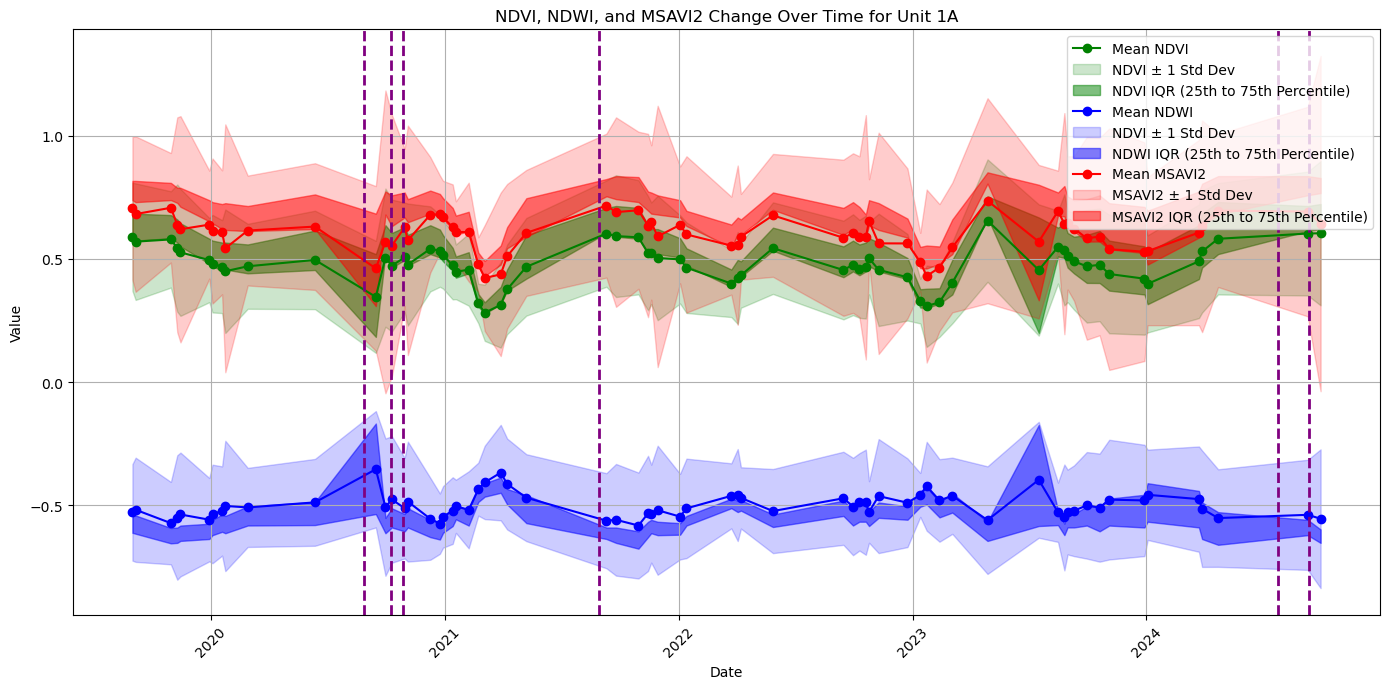

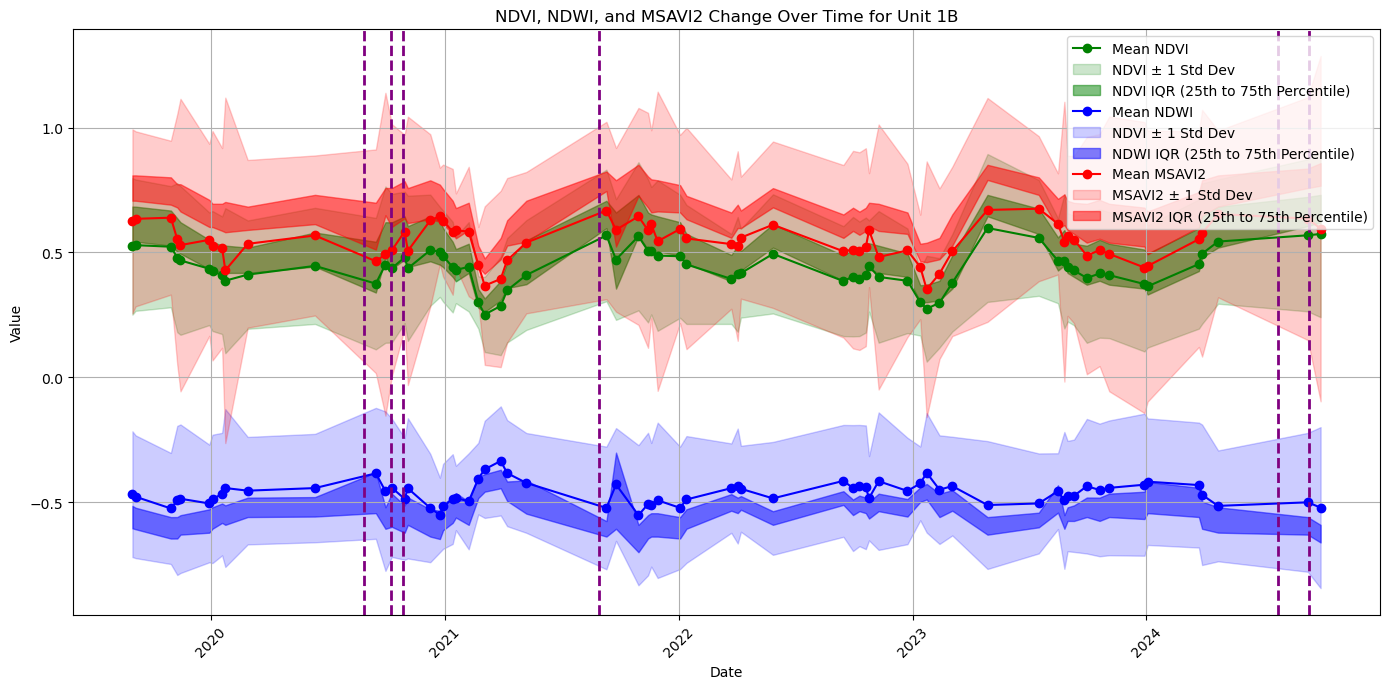

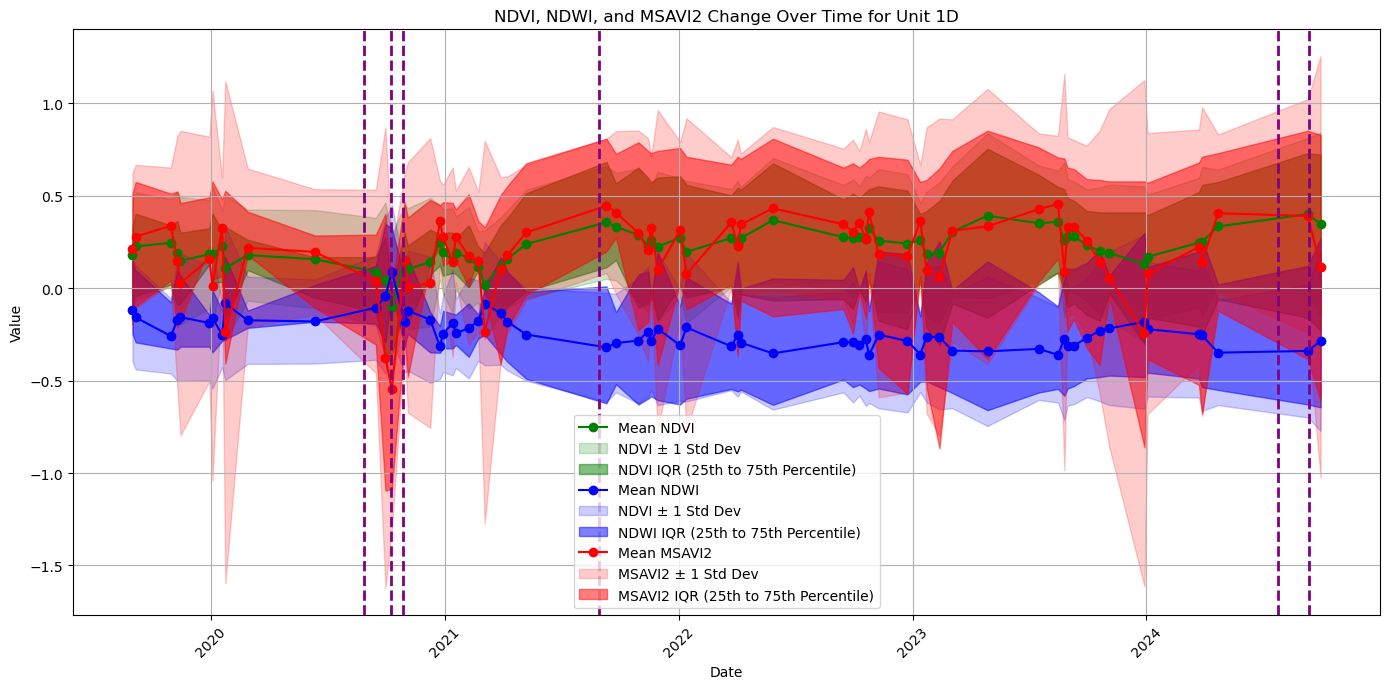

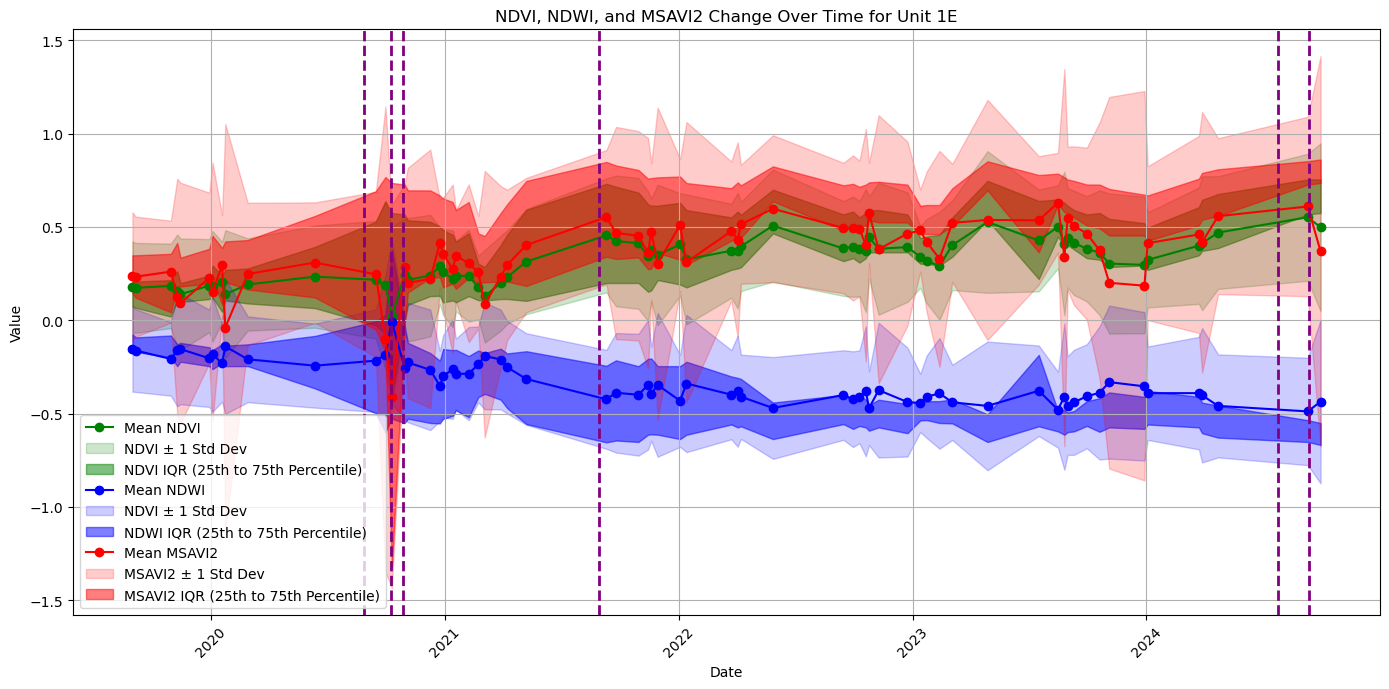

In [25]:
plot_VI_ts(sites['Site 3'], 'Unit 1A', 'together')
plot_VI_ts(sites['Site 2'], 'Unit 1B', 'together')
plot_VI_ts(sites['Site 0'], 'Unit 1D', 'together') # site finished in Sept 2019
plot_VI_ts(sites['Site 1'], 'Unit 1E', 'together') # site finished in Sept 2019

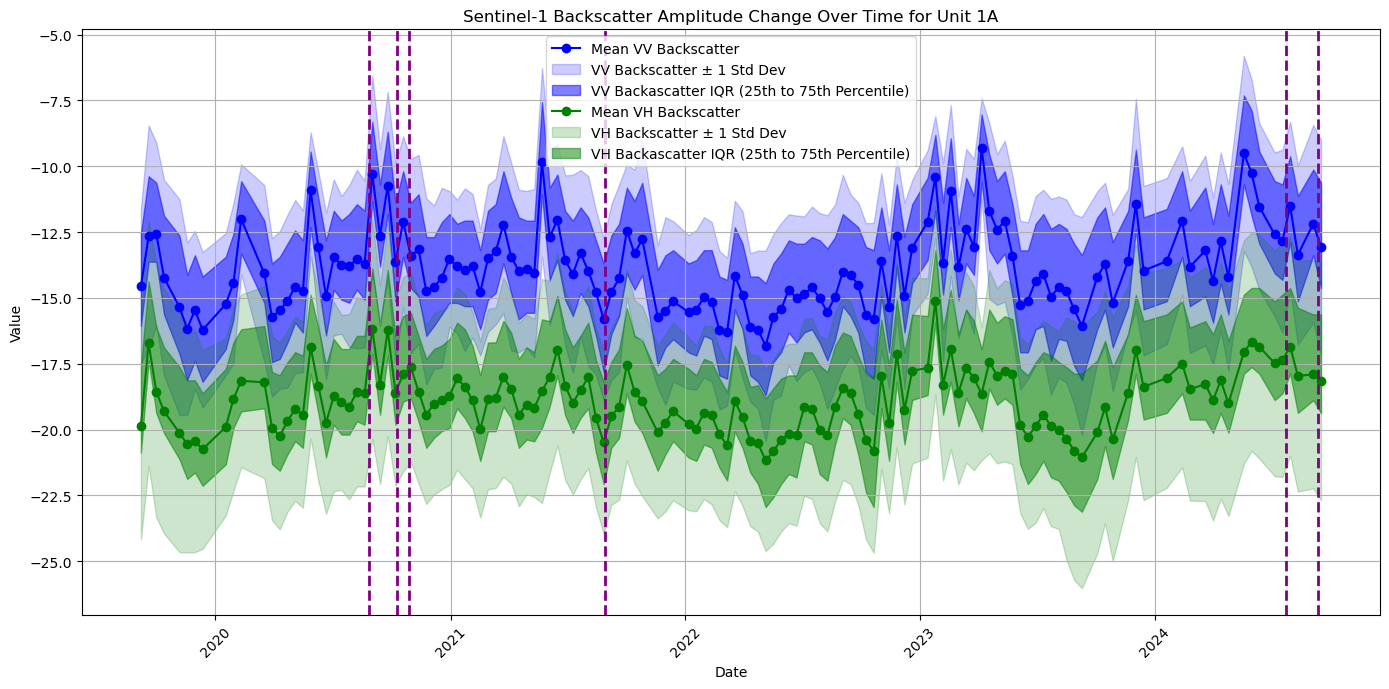

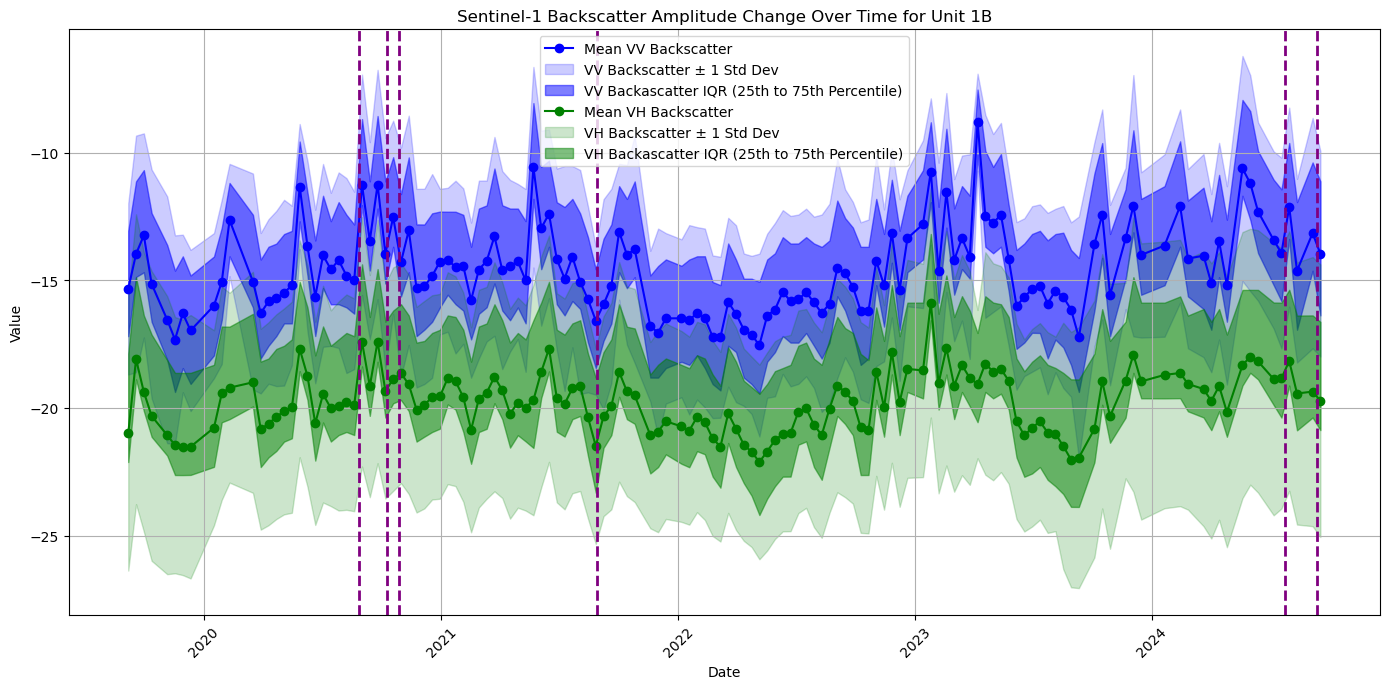

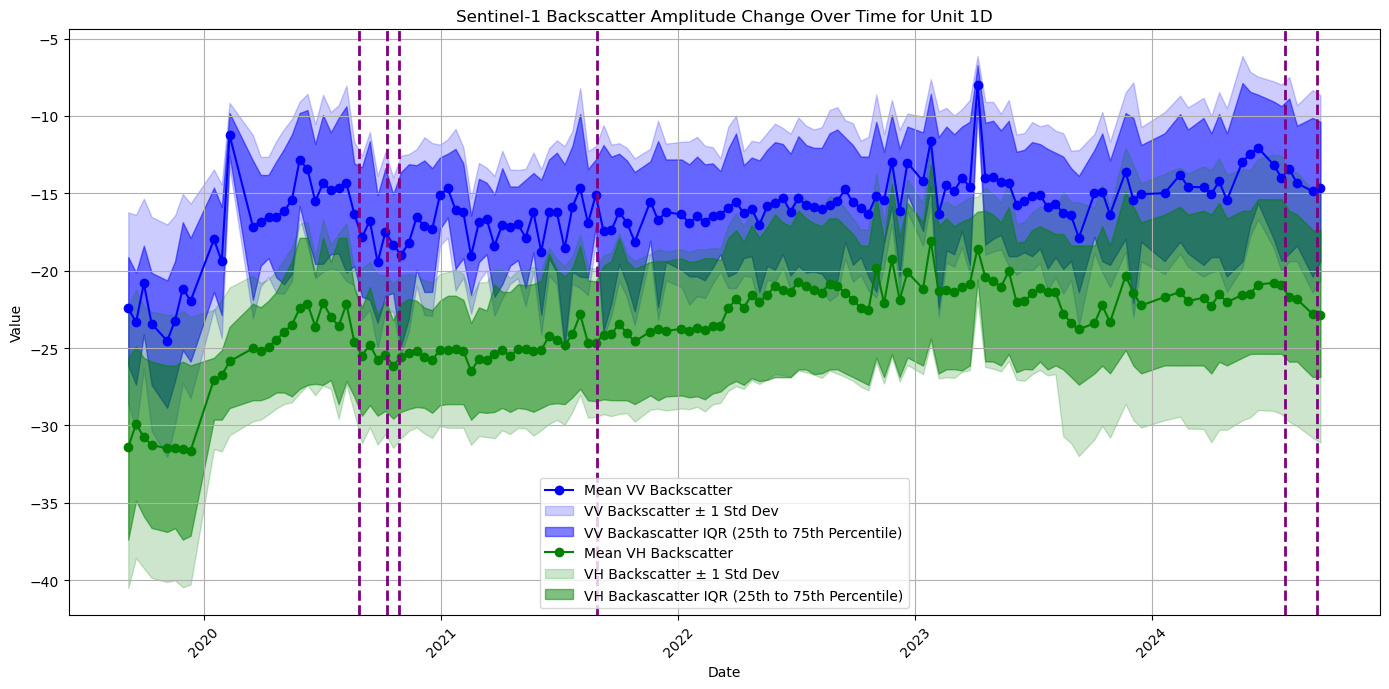

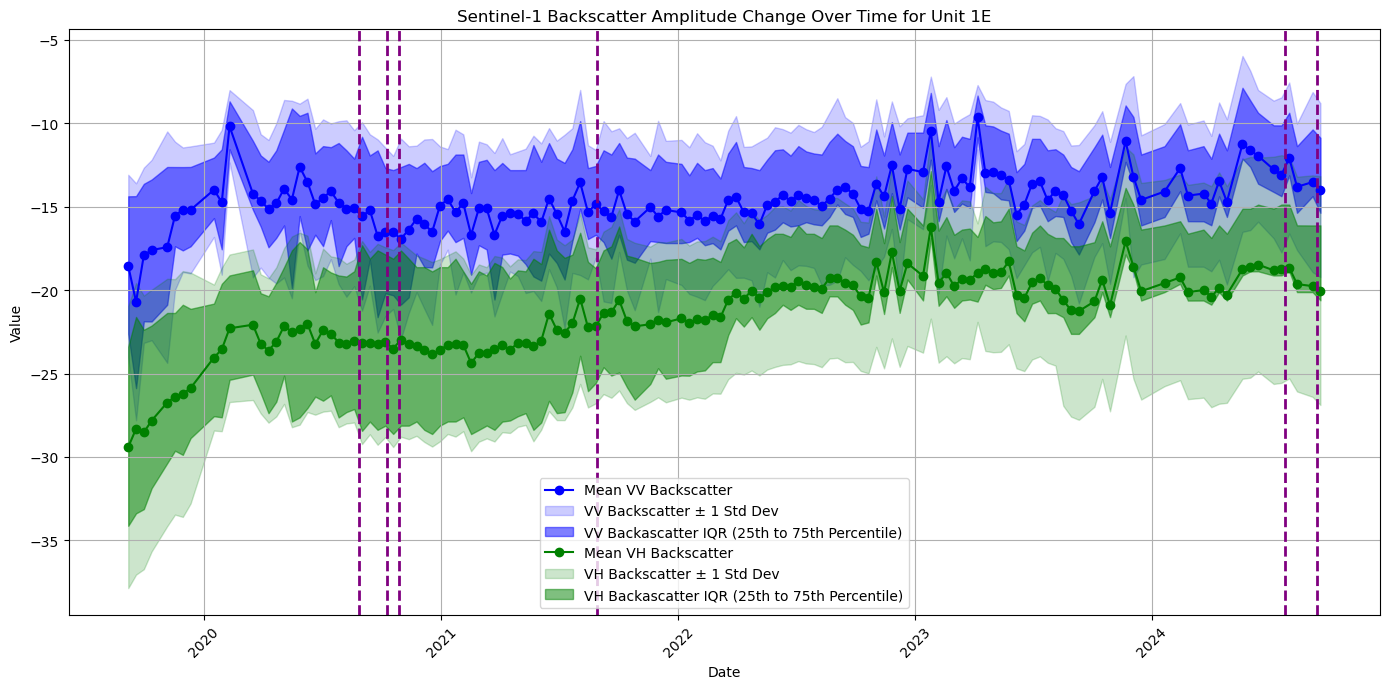

In [26]:
plot_GRD_ts(sites['Site 3'], 'Unit 1A', 'together', total_colls['s1'])
plot_GRD_ts(sites['Site 2'], 'Unit 1B', 'together', total_colls['s1'])
plot_GRD_ts(sites['Site 0'], 'Unit 1D', 'together', total_colls['s1']) # site finished in Sept 2019
plot_GRD_ts(sites['Site 1'], 'Unit 1E', 'together', total_colls['s1']) # site finished in Sept 2019

In [ ]:
# def plot_VI_ts_combined(aoi, aoi_str, plottype):
#     # Plotting the mean, standard deviation, and quartiles
#     if plottype == 'together':
    
#         plt.figure(figsize=(14, 7))

#         for imcoll in [total_colls['s2_10m_ndvi'], total_colls['s2_10m_ndwi']]:
#             if imcoll == total_colls['s2_10m_ndvi']:
#                 df_msavi2 = extract_stats_from_aoi(total_colls['s2_10m_msavi2'], 'MSAVI2', aoi)
#                 df_ndvi = extract_stats_from_aoi(imcoll, 'NDVI', aoi)

#                 # Replace NDVI/MSAVI2 values with NDVI where MSAVI2 > 0.6
#                 df_combined = df_msavi2.copy()
#                 condition = df_msavi2['mean'] > 0.6
#                 df_combined.loc[condition, 'mean'] = df_ndvi.loc[condition, 'mean']
#                 df_combined.loc[condition, 'stdDev'] = df_ndvi.loc[condition, 'stdDev']
#                 df_combined.loc[condition, 'p25'] = df_ndvi.loc[condition, 'p25']
#                 df_combined.loc[condition, 'p75'] = df_ndvi.loc[condition, 'p75']

#                 plt.plot(df_combined['date'], df_combined['mean'], color='green', marker='o', linestyle='-', label='Mean NDVI/MSAVI2 (with NDVI substitution)')
#                 plt.fill_between(df_combined['date'],
#                                 df_combined['mean'] - df_combined['stdDev'],
#                                 df_combined['mean'] + df_combined['stdDev'],
#                                 color='green', alpha=0.2, label='NDVI/MSAVI2 ± 1 Std Dev (with NDVI substitution)'
#                             )

#                 # Plot NDVI/MSAVI2 Interquartile Range (IQR)
#                 plt.fill_between(df_combined['date'],
#                                 df_combined['p25'],
#                                 df_combined['p75'],
#                                 color='green', alpha=0.5, linestyle='-', label='NDVI/MSAVI2 IQR (with NDVI substitution)'
#                             )

#             elif imcoll == total_colls['s2_10m_ndwi']:
#                 df_ndwi = extract_stats_from_aoi(imcoll, 'NDWI', aoi)
#                 plt.plot(df_ndwi['date'], df_ndwi['mean'], color='blue', marker='o', linestyle='-', label='Mean NDWI')
#                 plt.fill_between(df_ndwi['date'],
#                                     df_ndwi['mean'] - df_ndwi['stdDev'],
#                                     df_ndwi['mean'] + df_ndwi['stdDev'],
#                                     color='blue', alpha=0.2, label='NDWI ± 1 Std Dev'
#                                 )

#                 # Plot NDWI Interquartile Range (IQR)
#                 plt.fill_between(df_ndwi['date'],
#                                     df_ndwi['p25'],
#                                     df_ndwi['p75'],
#                                     color='blue', alpha=0.5, linestyle='-', label='NDWI IQR (25th to 75th Percentile)'
#                                 )
        


#         # Add vertical lines for Hurricane Laura and Hurricane Delta
#         storm_dates = {
#             'Hurricane Laura': pd.to_datetime('2020-08-27'),
#             'Hurricane Delta': pd.to_datetime('2020-10-09'),
#             'Hurricane Zeta': pd.to_datetime('2020-10-28'),
#             'Hurricane Ida': pd.to_datetime('2021-08-29'),
#             'Hurricane Beryl': pd.to_datetime('2024-07-24'),
#             'Hurricane Francine': pd.to_datetime('2024-09-11')
#         }

#         for storm, date in storm_dates.items():
#             if storm[0] == 'H':
#                 plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

#         # Customizing the plot
#         plt.xlabel('Date')
#         plt.ylabel('Value')
#         plt.title(f'NDVI/MSAVI2 and NDWI Change Over Time for {aoi_str}')
#         plt.xticks(rotation=45)
#         plt.legend()
#         plt.tight_layout()
#         plt.grid(True)

#         # Show plot
#         plt.show()
        
#     elif plottype == 'separate':
        
#         plt.figure(figsize=(14,7))

#         df_ndvi = extract_stats_from_aoi(total_colls['s2_10m_ndvi'], 'NDVI', aoi)
#         df_msavi2 = extract_stats_from_aoi(total_colls['s2_10m_msavi2'], 'MSAVI2', aoi)

#         # Replace NDVI/MSAVI2 values with NDVI where MSAVI2 > 0.6
#         df_combined = df_msavi2.copy()
#         condition = df_msavi2['mean'] > 0.6
#         df_combined.loc[condition, 'mean'] = df_ndvi.loc[condition, 'mean']
#         df_combined.loc[condition, 'stdDev'] = df_ndvi.loc[condition, 'stdDev']
#         df_combined.loc[condition, 'p25'] = df_ndvi.loc[condition, 'p25']
#         df_combined.loc[condition, 'p75'] = df_ndvi.loc[condition, 'p75']

#         plt.plot(df_combined['date'], df_combined['mean'], color='green', marker='o', linestyle='-', label='Mean NDVI/MSAVI2 (with NDVI substitution)')
#         plt.fill_between(df_combined['date'],
#                         df_combined['mean'] - df_combined['stdDev'],
#                         df_combined['mean'] + df_combined['stdDev'],
#                         color='green', alpha=0.2, label='NDVI/MSAVI2 ± 1 Std Dev (with NDVI substitution)'
#                     )

#         # Plot NDVI/MSAVI2 Interquartile Range (IQR)
#         plt.fill_between(df_combined['date'],
#                         df_combined['p25'],
#                         df_combined['p75'],
#                         color='green', alpha=0.5, linestyle='-', label='NDVI/MSAVI2 IQR (with NDVI substitution)'
#                     )
        
#         # Add vertical lines for Hurricane Laura and Hurricane Delta
#         storm_dates = {
#             'Hurricane Laura': pd.to_datetime('2020-08-27'),
#             'Hurricane Delta': pd.to_datetime('2020-10-09'),
#             'Hurricane Zeta': pd.to_datetime('2020-10-28'),
#             'Hurricane Ida': pd.to_datetime('2021-08-29'),
#             'Hurricane Beryl': pd.to_datetime('2024-07-24'),
#             'Hurricane Francine': pd.to_datetime('2024-09-11')
#         }

#         for storm, date in storm_dates.items():
#             if storm[0] == 'H':
#                 plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

#         # Customizing the plot
#         plt.xlabel('Date')
#         plt.ylabel('Value')
#         plt.title(f'Vegetation Change Over Time for {aoi_str}')
#         plt.xticks(rotation=45)
#         plt.legend()
#         plt.tight_layout()
#         plt.grid(True)

#         # Show plot
#         plt.show()

#         plt.figure(figsize=(14,7))

#         df = extract_stats_from_aoi(total_colls['s2_10m_ndwi'], 'NDWI', aoi)
#         plt.plot(df['date'], df['mean'], color='blue', marker='o', linestyle='-', label='Mean NDWI')
#         plt.fill_between(df['date'],
#                         df['mean'] - df['stdDev'],
#                         df['mean'] + df['stdDev'],
#                         color='blue', alpha=0.2, label='NDWI ± 1 Std Dev'
#                     )

#         # Plot NDWI Interquartile Range (IQR)
#         plt.fill_between(df['date'],
#                         df['p25'],
#                         df['p75'],
#                         color='blue', alpha=0.5, linestyle='-', label='NDWI IQR (25th to 75th Percentile)'
#                     )
        
#         # Add vertical lines for Hurricane Laura and Hurricane Delta
#         storm_dates = {
#             'Hurricane Laura': pd.to_datetime('2020-08-27'),
#             'Hurricane Delta': pd.to_datetime('2020-10-09'),
#             'Hurricane Zeta': pd.to_datetime('2020-10-28'),
#             'Hurricane Ida': pd.to_datetime('2021-08-29'),
#             'Hurricane Beryl': pd.to_datetime('2024-07-24'),
#             'Hurricane Francine': pd.to_datetime('2024-09-11')
#         }

#         for storm, date in storm_dates.items():
#             if storm[0] == 'H':
#                 plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

#         # Customizing the plot
#         plt.xlabel('Date')
#         plt.ylabel('Value')
#         plt.title(f'NDWI Change Over Time for {aoi_str}')
#         plt.xticks(rotation=45)
#         plt.legend()
#         plt.tight_layout()
#         plt.grid(True)

#         # Show plot
#         plt.show()

# ## Time series plot to show changes in NDVI and NDWI
# plot_VI_ts_combined(sites['Site 4'], 'Unit 1A', 'together')
# plot_VI_ts_combined(sites['Site 3'], 'Unit 1B', 'together')
# plot_VI_ts_combined(sites['Site 1'], 'Unit 1D', 'together') # site finished in Sept 2019
# plot_VI_ts_combined(sites['Site 2'], 'Unit 1E', 'together') # site finished in Sept 2019
# plot_VI_ts_combined(sites['Site 0'], '2023 Site', 'together') #Site Created in late 2023


# plot_VI_ts_combined(sites['Site 9'], 'Cycle 1', 'together')
# plot_VI_ts_combined(sites['Site 6'], 'Cycle 2', 'together')
# plot_VI_ts_combined(sites['Site 5'], 'Cycle 3', 'together') 
# plot_VI_ts_combined(sites['Site 7'], 'Cycle 4', 'together') 
# plot_VI_ts_combined(sites['Site 8'], 'Cycle 5', 'together') 

- Mean NDVI/NDWI Above Q3: small proportion of higher values pulling the mean upwards—perhaps due to localized greening or a recent vegetation growth spurt affecting only part of the area.
- Mean NDVI/NDWI Below Q1: extreme low values are present, pulling the mean down—potentially due to vegetation loss, seasonal dry periods, or land cover change in part of the region.

# Extract time series of Land Area Change (m2) for the marsh creation sites defined above

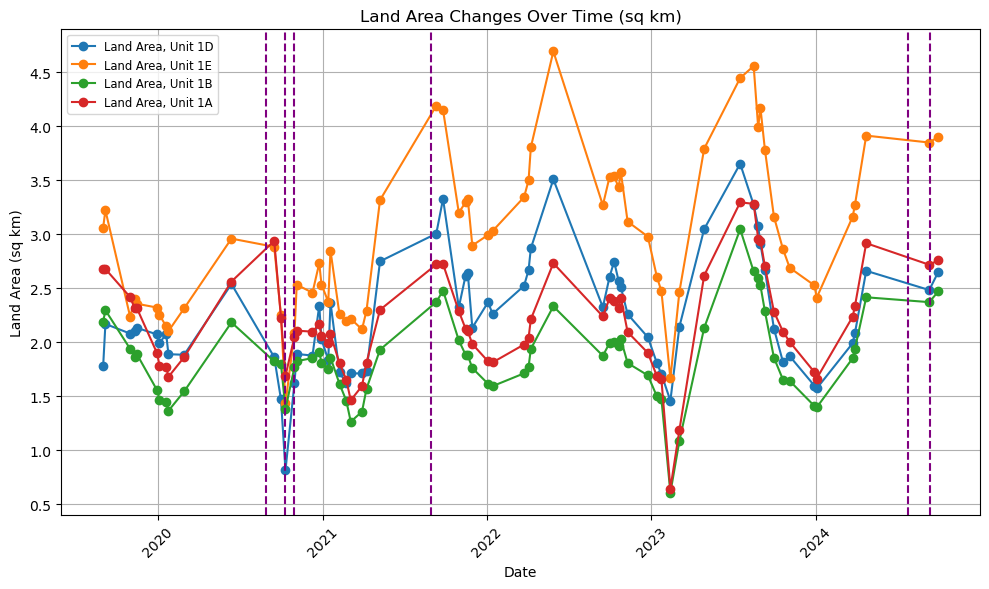

In [28]:
# for i, site in enumerate(sites):
# Apply land extraction to each NDWI and NDVI image
land_images = extract_land(
    total_colls['s2_10m'].map(lambda img: img.clip(aoi)), 
    total_colls['s2_10m_ndwi'].map(lambda img: img.clip(aoi)), 
    total_colls['s2_10m_ndvi'].map(lambda img: img.clip(aoi))
)

# Loop over the sites to calculate land area and get dates
land_area_lists = []
dates_lists = []

for idx, site_name in enumerate(sites):
    land_area_images = land_images.map(lambda img: img.clip(sites[f'Site {idx}'])).map(calculate_land_area)
    land_area_list = land_area_images.aggregate_array('total_land_area').getInfo()
    dates_list = land_area_images.aggregate_array('system:time_start').getInfo()
    land_area_lists.append(land_area_list)
    dates_lists.append(dates_list)

# Convert the UNIX timestamps to readable dates using the first site's dates as a reference
dates = [datetime.utcfromtimestamp(date / 1000).strftime('%Y-%m-%d') for date in dates_lists[0]]
df_data = {'Date': pd.to_datetime(dates)}  # Convert to datetime format

# Add land area for each site to the dataframe
for idx, site_name in enumerate(sites):
    df_data[f'Land Area (sq km), {site_name}'] = land_area_lists[idx]

    df = pd.DataFrame(df_data)

# Correct storm dates in 'YYYYMMDD' format and convert to datetime
storm_dates = {
    'Hurricane Laura': datetime.strptime('2020-08-27', '%Y-%m-%d'),
    'Hurricane Delta': datetime.strptime('2020-10-09', '%Y-%m-%d'),
    'Hurricane Zeta': datetime.strptime('2020-10-28', '%Y-%m-%d'),
    'Hurricane Ida': datetime.strptime('2021-08-29', '%Y-%m-%d'),
    'Hurricane Beryl': datetime.strptime('2024-07-24', '%Y-%m-%d'),
    'Hurricane Francine': datetime.strptime('2024-09-11', '%Y-%m-%d')
}

# Plotting the land area over time for each site
plt.figure(figsize=(10, 6))

for idx, site_name in enumerate(sites):
    if site_name == 'Site 0':
        plt.plot(df['Date'], df[f'Land Area (sq km), {site_name}'], marker='o', label=f'Land Area, Unit 1D')
    elif site_name == 'Site 1':
        plt.plot(df['Date'], df[f'Land Area (sq km), {site_name}'], marker='o', label=f'Land Area, Unit 1E')     
    elif site_name == 'Site 2':
        plt.plot(df['Date'], df[f'Land Area (sq km), {site_name}'], marker='o', label=f'Land Area, Unit 1B')
    elif site_name == 'Site 3':
        plt.plot(df['Date'], df[f'Land Area (sq km), {site_name}'], marker='o', label=f'Land Area, Unit 1A') 

# Adding hurricane event lines
for storm, date in storm_dates.items():
    plt.axvline(x=date, color='purple', linestyle='--', linewidth=1.5) #, label=f'{storm}}'

# Labels and formatting
plt.xlabel('Date')
plt.ylabel('Land Area (sq km)')
plt.title(f'Land Area Changes Over Time (sq km)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper left', fontsize='small')

# Show plot
plt.tight_layout()
plt.show()

# SAR Supervised Classification from Sentinel-2 Land Masking
- these results are not very good, the dielectrics within the sediment causes the returned VV and VH signals to be noisy, or blend in with the surrounding water areas
- will try to train on VV/VH ratio, instead of the two bands indidividually, can also include GLCM texture features

In [38]:
s1filt = MultiTemporal_Filter(total_colls['s1'], 3, 'LEE SIGMA', total_colls['s1'].size().getInfo())
# s1filt = MonoTemporal_Filter(total_colls['s1'], 5, 'LEE SIGMA')

In [39]:
s2_date_list = land_images.map(get_date).aggregate_array('date').getInfo()
# s1_date_list = total_colls['s1'].map(get_date).aggregate_array('date').getInfo()
s1_date_list = s1filt.map(get_date).aggregate_array('date').getInfo()

# Convert date strings to datetime objects
sentinel1_dates_dt = [datetime.strptime(date, '%Y-%m-%d') for date in s1_date_list]
sentinel2_dates_dt = [datetime.strptime(date, '%Y-%m-%d') for date in s2_date_list]

# Find the closest Sentinel-1 dates for each Sentinel-2 date
matched_dates = find_closest_dates(sentinel2_dates_dt, sentinel1_dates_dt)

matched_collection = match_collections_by_dates(land_images, s1filt, matched_dates)

In [40]:
# Function to sample land pixels from each image in the collection
def sample_land_pixels(image):
    # Sample the pixels for all bands, and include the 'land_label' as a property
    sampled_pixels = image.sample(
        # region=roi,                   # Specify the region of interest
        scale=10,                     # Resolution of the data
        numPixels=1000,               # Adjust for how many samples you want
        geometries=True               # Include geometries for spatial data if necessary
    )
    
    return sampled_pixels

# Map the function over the entire collection
sampled_land_collection = matched_collection.map(sample_land_pixels)

# Flatten the collection into a single FeatureCollection (one table for all images)
all_sampled_pixels = sampled_land_collection.flatten()

In [41]:
# Define a function to label Sentinel-1 pixels based on the RGB mask
def label_pixels(image):
    # Use the mask from the RGB image to create the land/water label
    land_mask = image.select(['B8']).mask().reduce(ee.Reducer.min())

    # Label the Sentinel-1 pixels: 1 for land, 0 for water
    labeled_backscatter = image.select('VV').where(land_mask.eq(1), 1).where(land_mask.eq(0), 0).rename('label')
    # sar_wlm.append(labeled_backscatter.set('system:time_start', match_sar.get('system:time_start')))

    # Return the labeled Sentinel-1 image
    # return labeled_backscatter.set('system:time_start', match_sar.get('system:time_start'))
    # return ee.ImageCollection(sar_wlm)
    return image.addBands(labeled_backscatter)

# Map the labeling function over the Sentinel-1 collection
labeled_collection = matched_collection.map(label_pixels).select('VV', 'VH', 'label')

# Print or display a few of the labeled images to verify
print(labeled_collection.size().getInfo())  # Prints the number of images processed

66


In [42]:
# Function to sample from each image in the collection
def sample_image(image):
    return image.sample(
        region=aoi,         # Define your area of interest
        scale=10,            # Set the scale (resolution) to sample from
        numPixels=5000,      # Set the number of pixels to sample (adjust based on your data)
        geometries=True      # Set to True if you want to keep the pixel's geometry
    )

# Use map() to sample each image in the collection
sampled_images = labeled_collection.map(sample_image)
training_data = sampled_images.flatten()

In [43]:
# Train a Random Forest classifier
classifier = ee.Classifier.smileRandomForest(numberOfTrees=10).train(
    features=training_data,
    classProperty='label',
    inputProperties=['VV', 'VH']  # Adjust based on your feature bands
)

def classify_ims(image):
    label = image.classify(classifier).rename('land_label')
    return image.addBands([label])

# Apply the classifier to an image (or image collection)
classified_images = s1filt.map(classify_ims).select(['land_label'])

In [45]:
maptest = geemap.Map()
maptest.centerObject(aoi, 12)

class_ims = classified_images.toList(classified_images.size())

for i in range(classified_images.size().getInfo()//60):
    image = ee.Image(class_ims.get(-i))
    maptest.addLayer(image.select('land_label'), {'min': 0, 'max': 1, 'palette': ['blue', 'green']}, f'Labeled Sentinel-1 {i}')
    # maptest.addLayer(image.select('label'), {'min': 0, 'max': 1, 'palette': ['blue', 'green']}, f'test{i}')
    rgbims = total_colls['s2_10m'].toList(total_colls['s2_10m'].size())
    add_rgb_to_map(ee.Image(rgbims.get(-i)), maptest)

    # add_sar_to_map(image, maptest, 'VV')
    # add_sar_to_map(image, maptest, 'VH')

# Display the maptest.
maptest.addLayerControl(position = 'topright')
maptest

EEException: User memory limit exceeded.

# Testing
1. Include VV/VH ratio in supervised classification training
2. Include GLCM texture features in supervised classification training
3. Time series of area change for Creation Sites using Sentinel-1, compare with Sentinel-2 time series
4. Export imagery?

May need to export the s1 and s2 (rgb, ndvi, ndwi, masvi2, bsi) images for creating a more robust model for classification, similar to Pena et el 2024.

- time series of area change from pixel change detection for objects
- examine the ndwi, ndvi, msavi2, vv amplitude, and vh amplitude in the objects as they change throughout time, compare with area changes?


Once able to spatially estimate shoreline/area changes, use those to estimate area changes for the marsh creation sites. (Once the area is estiamted, the volumetric changes can be estimated using closure phase corrected InSAR)